# Исследование показов рекламы в мобильной игре

Заказчик этого исследования — геймдев-компания, зарабатывающая на показе рекламы.  
   
Есть несколько форматов:
- int – полноэкранная реклама; 
- banner – горизонтальный баннер, висит внизу экрана пока юзер играет; 
- rv – видео, которое юзер смотрит по желанию и за просмотр получает монетки или др. ресурсы. 
Информация о каждом показе отправляется в аналитику и содержит доход от показа, формат показанной рекламы, рекламную сеть от которой был показ и др.
  
**Задача:** провести исследование показов рекламы с целью понять на сколько отличается eCPM в зависимости от географии (города) юзера, версии ОС и других параметров. Интересны любые инсайты и находки по eCPM-ам.  
  
В нашем распоряжении данные, которые содержат информацию о показах рекламы для юзеров США.

## Обзор данных

In [297]:
# импортирование необходимых библиотек и настройка отображения значений
import pandas as pd 
import matplotlib.pyplot as plt

pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('mode.chained_assignment', None)

In [158]:
# прочитаем файл с данными о рекламе и запишем в переменную df
df = pd.read_csv('datasets/us events ad_revenue filtered 03.02-07.02.csv')

In [159]:
# получим первые строки датасета
df.head()

,profile_id,os_version,device_manufacturer,device_model,device_type,device_locale,event_name,event_json,event_datetime,event_timestamp,event_receive_datetime,event_receive_timestamp,connection_type,operator_name,country_iso_code,city
0,JLjpGzDHBQm,11,Samsung,Galaxy Tab S6,tablet,en_US,c_ad_revenue,"{""ad_type"":""banner"",""placement"":"""",""view_index...",2022-02-04 20:02:28,1643994148,2022-02-06 17:58:19,1644159499,wifi,NaN,US,Norwalk
1,JLjpGzDHBQm,11,Samsung,Galaxy Tab S6,tablet,en_US,c_ad_revenue,"{""ad_type"":""banner"",""placement"":"""",""view_index...",2022-02-04 20:02:45,1643994165,2022-02-06 17:58:19,1644159499,wifi,NaN,US,Norwalk
2,JLkVacrzHY6,11,Google,Pixel 2,phone,en_US,c_ad_revenue,"{""ad_type"":""banner"",""placement"":"""",""view_index...",2022-02-05 17:53:05,1644072785,2022-02-06 16:59:29,1644155969,wifi,Verizon,US,Charlotte
3,JMC6wG3cX0f,10,Samsung,Galaxy S9,phone,en_US,c_ad_revenue,"{""ad_type"":""int"",""placement"":""next_level"",""vie...",2022-02-06 17:09:01,1644156541,2022-02-06 17:09:24,1644156564,wifi,T-Mobile,US,Cocoa
4,JLzWWTJfi1b,10,Samsung,Galaxy S9,phone,en_US,c_ad_revenue,"{""ad_type"":""banner"",""placement"":"""",""view_index...",2022-02-06 17:15:38,1644156938,2022-02-06 17:16:16,1644156976,cell,Verizon,US,NaN


Данные в колонке `event_json` записаны в формате json - нужно преобразовать колонку в объект Python для удобной работы с данными.

In [160]:
# напишем функцию для преобразования в словарь
def to_dict(row):
    row = json.loads(row)
    return row

In [161]:
# применим функцию к колонке event_json
df['event_json'] = df['event_json'].apply(to_dict)

Далее нам нужно разбить словарь на отдельные колонки и добавить в таблицу.

In [162]:
# преобразуем словарь в отдельные колонки
df[['ad_type',
 'placement',
 'view_index',
 'session_view_index',
 'cur_ticks',
 'session_length',
 'revenue',
 'ads_ltv',
 'ecpm_sma',
 'normalized_ecpm_sma',
 'value',
 'currency',
 'ad_country_code',
 'network_name',
 'ad_unit_id',
 'ad_network_placement',
 'creativeId']] = pd.json_normalize(df['event_json'])
df.head()

,profile_id,os_version,device_manufacturer,device_model,device_type,device_locale,event_name,event_json,event_datetime,event_timestamp,...,ads_ltv,ecpm_sma,normalized_ecpm_sma,value,currency,ad_country_code,network_name,ad_unit_id,ad_network_placement,creativeId
0,JLjpGzDHBQm,11,Samsung,Galaxy Tab S6,tablet,en_US,c_ad_revenue,"{'ad_type': 'banner', 'placement': '', 'view_i...",2022-02-04 20:02:28,1643994148,...,0.488,0.512,0.512,0.001,USD,US,Google AdMob,64c6b1114ea8c1cc,ca-app-pub-7511632782617496/8825263691,CJ3XirfD5vUCFYPnKAUdG3MOYQ
1,JLjpGzDHBQm,11,Samsung,Galaxy Tab S6,tablet,en_US,c_ad_revenue,"{'ad_type': 'banner', 'placement': '', 'view_i...",2022-02-04 20:02:45,1643994165,...,0.488,0.511,0.511,0.001,USD,US,Google AdMob,64c6b1114ea8c1cc,ca-app-pub-7511632782617496/8825263691,CNa-lL_D5vUCFZrpKAUdU2QBDQ
2,JLkVacrzHY6,11,Google,Pixel 2,phone,en_US,c_ad_revenue,"{'ad_type': 'banner', 'placement': '', 'view_i...",2022-02-05 17:53:05,1644072785,...,0.678,0.929,0.929,0.002,USD,US,APPLOVIN_EXCHANGE,64c6b1114ea8c1cc,banner_regular,pandora-58
3,JMC6wG3cX0f,10,Samsung,Galaxy S9,phone,en_US,c_ad_revenue,"{'ad_type': 'int', 'placement': 'next_level', ...",2022-02-06 17:09:01,1644156541,...,0.014,13.783,13.894,0.014,USD,US,AppLovin,3ab7705b07ebb75f,inter_regular,13045364
4,JLzWWTJfi1b,10,Samsung,Galaxy S9,phone,en_US,c_ad_revenue,"{'ad_type': 'banner', 'placement': '', 'view_i...",2022-02-06 17:15:38,1644156938,...,0.061,1.660,1.660,0.007,USD,US,Google AdMob,64c6b1114ea8c1cc,ca-app-pub-7511632782617496/6197324251,CMTi5e-h6_UCFUdVwQodt9EIMw


In [163]:
# посмотрим, как изменился размер датасета
df.shape

(860079, 33)

In [164]:
# посмотрим общую информацию о датасете
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 860079 entries, 0 to 860078
Data columns (total 33 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   profile_id               860065 non-null  object 
 1   os_version               860079 non-null  object 
 2   device_manufacturer      860079 non-null  object 
 3   device_model             860079 non-null  object 
 4   device_type              860079 non-null  object 
 5   device_locale            860079 non-null  object 
 6   event_name               860079 non-null  object 
 7   event_json               860079 non-null  object 
 8   event_datetime           860079 non-null  object 
 9   event_timestamp          860079 non-null  int64  
 10  event_receive_datetime   860079 non-null  object 
 11  event_receive_timestamp  860079 non-null  int64  
 12  connection_type          860079 non-null  object 
 13  operator_name            841200 non-null  object 
 14  coun

**Документация к данным:**  
  
Столбец `profile_id` – id юзера  
  
Столбец `event_json` содержит данные о событии показа рекламы:
- `ad_type` – формат рекламы (int, banner или rv)
- `placement` – когда/где был показ рекламы в игре
- `view_index` – номер показа конкретного формата рекламы для юзера (не поддерживается для баннеров)
- `revenue` – доход от конкретного показа рекламы (eCPM = revenue * 1000)
- `ads_ltv` – накапливающийся доход от рекламы, равен сумме всех revenue юзера
- `network_name` – рекламная сеть, от которой был показ   


### Вывод

В нашем датасете 860079 строк и 33 колонки. Изначально было 16 колонок: колонку `event_json` преобразовали в словарь и разбили на дополнительные колонки.  
В данных имеются пропуски и несоответствие типов данных.

## Предобработка данных

### Проверка типов данных

In [165]:
# посмотрим, какими типами данных представлены значения
df.dtypes

profile_id                  object
os_version                  object
device_manufacturer         object
device_model                object
device_type                 object
device_locale               object
event_name                  object
event_json                  object
event_datetime              object
event_timestamp              int64
event_receive_datetime      object
event_receive_timestamp      int64
connection_type             object
operator_name               object
country_iso_code            object
city                        object
ad_type                     object
placement                   object
view_index                   int64
session_view_index           int64
cur_ticks                    int64
session_length             float64
revenue                    float64
ads_ltv                    float64
ecpm_sma                   float64
normalized_ecpm_sma        float64
value                      float64
currency                    object
ad_country_code     

В колонках `event_datetime` и `event_receive_datetime` представлена дата - преобразуем тип данных из object в datetime.

In [166]:
df.event_datetime = pd.to_datetime(df.event_datetime, format='%Y-%m-%d %H:%M:%S')
df.event_receive_datetime = pd.to_datetime(df.event_receive_datetime, format='%Y-%m-%d %H:%M:%S')

В колонке `os_version` представлены числовые данные, поэтому нужно заменить тип object на float.

In [167]:
df.os_version = pd.to_numeric(df.os_version, errors='coerce')

#### Вывод

В этом разделе:  
- в колонках `event_datetime` и `event_receive_datetime` поменяли тип данных на datetime
- в колонке `os_version` поменяли тип данных на числовой

### Изучение пропусков

In [168]:
# получим общую информацию о количестве пропусков в данных
df.isna().sum()

profile_id                     14
os_version                  21831
device_manufacturer             0
device_model                    0
device_type                     0
device_locale                   0
event_name                      0
event_json                      0
event_datetime                  0
event_timestamp                 0
event_receive_datetime          0
event_receive_timestamp         0
connection_type                 0
operator_name               18879
country_iso_code                0
city                       323708
ad_type                         0
placement                       0
view_index                      0
session_view_index              0
cur_ticks                       0
session_length                  0
revenue                         0
ads_ltv                         0
ecpm_sma                        0
normalized_ecpm_sma             0
value                           0
currency                        0
ad_country_code                 0
network_name  

В колонке с городом больше всего пропусков.

In [169]:
# посмотрим на данные с пропусками в city
df.query('city.isna()').sample(10)

,profile_id,os_version,device_manufacturer,device_model,device_type,device_locale,event_name,event_json,event_datetime,event_timestamp,...,ads_ltv,ecpm_sma,normalized_ecpm_sma,value,currency,ad_country_code,network_name,ad_unit_id,ad_network_placement,creativeId
564308,JLkbGWmQep8,11.000,Samsung,Galaxy Note10+,phone,en_US,c_ad_revenue,"{'ad_type': 'banner', 'placement': '', 'view_i...",2022-02-06 05:30:00,1644114600,...,0.400,2.094,2.094,0.002,USD,US,Google AdMob,64c6b1114ea8c1cc,ca-app-pub-7511632782617496/4884242584,CIn_74KE6vUCFSAEigMdp54Bbw
529078,JLs3HLc0iMD,9.000,LG,LG G7 ThinQ,phone,en_US,c_ad_revenue,"{'ad_type': 'banner', 'placement': '', 'view_i...",2022-02-06 23:06:14,1644177974,...,10.018,0.041,0.041,0.000,USD,US,APPLOVIN_EXCHANGE,64c6b1114ea8c1cc,banner_regular,112845
540196,JLvnL9iKvxo,10.000,Samsung,Galaxy S9,phone,en_US,c_ad_revenue,"{'ad_type': 'banner', 'placement': '', 'view_i...",2022-02-07 04:25:28,1644197128,...,0.102,0.044,0.044,0.000,USD,US,APPLOVIN_EXCHANGE,64c6b1114ea8c1cc,banner_regular,1841075
280202,JLsTvN0wPAR,12.000,Samsung,Galaxy S21 Ultra 5G,phone,en_US,c_ad_revenue,"{'ad_type': 'banner', 'placement': '', 'view_i...",2022-02-05 21:42:41,1644086561,...,0.118,0.605,0.605,0.000,USD,US,APPLOVIN_EXCHANGE,64c6b1114ea8c1cc,banner_regular,nOq8Z6pPrSKxBK6h:a:wVVyI4z9BIXPaszL
114462,JLvOoym6QPB,12.000,Samsung,SM-G991U,phone,en_US,c_ad_revenue,"{'ad_type': 'int', 'placement': 'next_level', ...",2022-02-05 14:52:32,1644061952,...,0.063,58.012,58.480,0.058,USD,US,Google AdMob,3ab7705b07ebb75f,ca-app-pub-7511632782617496/8484360640,CNeiy7e_6PUCFZn09QIdZMgEaQ
744956,JLwoHHfzRuJ,12.000,Samsung,Galaxy S10e,phone,en_US,c_ad_revenue,"{'ad_type': 'banner', 'placement': '', 'view_i...",2022-02-07 02:19:14,1644189554,...,0.141,0.433,0.433,0.000,USD,US,Google AdMob,64c6b1114ea8c1cc,ca-app-pub-7511632782617496/8825263691,CIHju6yb7PUCFZVPYgodDfMLRA
362270,JLyTsOC8gcp,10.000,Samsung,Galaxy S9+,phone,en_US,c_ad_revenue,"{'ad_type': 'banner', 'placement': '', 'view_i...",2022-02-06 09:33:43,1644129223,...,0.924,0.418,0.418,0.000,USD,US,Google AdMob,64c6b1114ea8c1cc,ca-app-pub-7511632782617496/8825263691,CNvX5sm66vUCFWojswAd7jkOqA
809770,JLSBWgR8U6m,11.000,LG,VELVET,phone,en_US,c_ad_revenue,"{'ad_type': 'banner', 'placement': '', 'view_i...",2022-02-03 21:07:24,1643911644,...,0.855,4.571,4.571,0.007,USD,US,Google AdMob,64c6b1114ea8c1cc,ca-app-pub-7511632782617496/6197324251,CJai3oWQ5PUCFe45wQodHvsCfw
347313,JLkavQUMeHc,12.000,Samsung,SM-G991U,phone,en_US,c_ad_revenue,"{'ad_type': 'banner', 'placement': '', 'view_i...",2022-02-05 04:08:54,1644023334,...,1.932,0.533,0.533,0.001,USD,US,Google AdMob,64c6b1114ea8c1cc,ca-app-pub-7511632782617496/8825263691,CJ6j2pCw5_UCFSM1wQodg3kOQQ
662048,JL5Tof1j4Ek,11.000,Samsung,Galaxy A20,phone,en_US,c_ad_revenue,"{'ad_type': 'banner', 'placement': '', 'view_i...",2022-02-04 01:46:05,1643928365,...,11.076,0.875,0.875,0.001,USD,US,Google AdMob,64c6b1114ea8c1cc,ca-app-pub-7511632782617496/8825263691,CI-lrazO5PUCFf7NKAUdvn8NMg


In [170]:
# посмотрим на данные с пропусками в os_version
df.query('os_version.isna()').sample(10)

,profile_id,os_version,device_manufacturer,device_model,device_type,device_locale,event_name,event_json,event_datetime,event_timestamp,...,ads_ltv,ecpm_sma,normalized_ecpm_sma,value,currency,ad_country_code,network_name,ad_unit_id,ad_network_placement,creativeId
36355,JLk2A8RJLwi,NaN,Samsung,Galaxy J3(2016),phone,en_US,c_ad_revenue,"{'ad_type': 'banner', 'placement': '', 'view_i...",2022-02-04 21:15:06,1643998506,...,0.402,0.042,0.042,0.000,USD,US,APPLOVIN_EXCHANGE,64c6b1114ea8c1cc,banner_regular,6735200
608367,JL5EghbcBgD,NaN,Samsung,Galaxy S7,phone,en_US,c_ad_revenue,"{'ad_type': 'banner', 'placement': '', 'view_i...",2022-02-07 02:38:40,1644190720,...,0.565,0.052,0.052,0.000,USD,US,APPLOVIN_EXCHANGE,64c6b1114ea8c1cc,banner_regular,1801342
700627,JLOBhhFdYn9,NaN,Samsung,Galaxy J7 Prime,phone,en_US,c_ad_revenue,"{'ad_type': 'banner', 'placement': '', 'view_i...",2022-02-05 22:44:33,1644090273,...,2.506,0.141,0.141,0.000,USD,US,APPLOVIN_EXCHANGE,64c6b1114ea8c1cc,banner_regular,241819
304399,JL5EghbcBgD,NaN,Samsung,Galaxy S7,phone,en_US,c_ad_revenue,"{'ad_type': 'banner', 'placement': '', 'view_i...",2022-02-05 05:13:52,1644027232,...,0.347,0.029,0.029,0.000,USD,US,APPLOVIN_EXCHANGE,64c6b1114ea8c1cc,banner_regular,119_4902532
425850,JL9rCEVGtaT,NaN,LG,LG K8(2018),phone,en_US,c_ad_revenue,"{'ad_type': 'banner', 'placement': '', 'view_i...",2022-02-03 17:33:04,1643898784,...,1.249,0.034,0.034,0.000,USD,US,APPLOVIN_EXCHANGE,64c6b1114ea8c1cc,banner_regular,240070
603691,JLa1JPys23P,NaN,Kyocera,DuraForce PRO with Sapphire Shield,phone,en_US,c_ad_revenue,"{'ad_type': 'banner', 'placement': '', 'view_i...",2022-02-06 23:01:59,1644177719,...,1.149,0.078,0.078,0.000,USD,US,Google AdMob,64c6b1114ea8c1cc,ca-app-pub-7511632782617496/8825263691,CNzFoaDv6_UCFUSA7AodEuAIFQ
481505,JL3rOsm6i1E,NaN,Samsung,Galaxy J7 V,phone,en_US,c_ad_revenue,"{'ad_type': 'banner', 'placement': '', 'view_i...",2022-02-05 06:53:51,1644033231,...,0.269,0.298,0.298,0.000,USD,US,APPLOVIN_EXCHANGE,64c6b1114ea8c1cc,banner_regular,191752
384649,JLs40FXvb3k,NaN,Samsung,Galaxy S7,phone,en_US,c_ad_revenue,"{'ad_type': 'banner', 'placement': '', 'view_i...",2022-02-06 00:03:34,1644095014,...,0.690,0.495,0.495,0.000,USD,US,Google AdMob,64c6b1114ea8c1cc,ca-app-pub-7511632782617496/8825263691,CIyz9JS76fUCFVMK0AQddeoM0A
531566,JL9rCEVGtaT,NaN,LG,LG K8(2018),phone,en_US,c_ad_revenue,"{'ad_type': 'banner', 'placement': '', 'view_i...",2022-02-04 02:37:24,1643931444,...,1.582,0.032,0.032,0.000,USD,US,APPLOVIN_EXCHANGE,64c6b1114ea8c1cc,banner_regular,164862
608422,JL5EghbcBgD,NaN,Samsung,Galaxy S7,phone,en_US,c_ad_revenue,"{'ad_type': 'banner', 'placement': '', 'view_i...",2022-02-07 02:52:53,1644191573,...,0.581,0.025,0.025,0.000,USD,US,APPLOVIN_EXCHANGE,64c6b1114ea8c1cc,banner_regular,119_4949094


In [171]:
# посмотрим на данные с пропусками в operator_name
df.query('operator_name.isna()').sample(10)

,profile_id,os_version,device_manufacturer,device_model,device_type,device_locale,event_name,event_json,event_datetime,event_timestamp,...,ads_ltv,ecpm_sma,normalized_ecpm_sma,value,currency,ad_country_code,network_name,ad_unit_id,ad_network_placement,creativeId
578988,JLmiqBNDAOz,10.000,Samsung,Galaxy Tab A 8.0,tablet,en_US,c_ad_revenue,"{'ad_type': 'banner', 'placement': '', 'view_i...",2022-02-07 00:20:15,1644182415,...,0.594,0.177,0.177,0.000,USD,US,APPLOVIN_EXCHANGE,64c6b1114ea8c1cc,banner_regular,219879
566637,JLyTsOC8gcp,10.000,Samsung,Galaxy S9+,phone,en_US,c_ad_revenue,"{'ad_type': 'banner', 'placement': '', 'view_i...",2022-02-07 22:01:16,1644260476,...,1.622,0.057,0.057,0.000,USD,US,APPLOVIN_EXCHANGE,64c6b1114ea8c1cc,banner_regular,2823751625
744027,JLLNjsVgVOp,7.000,Verizon Wireless,Ellipsis ® 10 HD,tablet,en_US,c_ad_revenue,"{'ad_type': 'banner', 'placement': '', 'view_i...",2022-02-03 02:02:23,1643842943,...,1.183,0.068,0.068,0.000,USD,US,APPLOVIN_EXCHANGE,64c6b1114ea8c1cc,banner_regular,119_4941398
75652,JLLNjsVgVOp,7.000,Verizon Wireless,Ellipsis ® 10 HD,tablet,en_US,c_ad_revenue,"{'ad_type': 'banner', 'placement': '', 'view_i...",2022-02-05 04:01:18,1644022878,...,1.472,0.043,0.043,0.000,USD,US,APPLOVIN_EXCHANGE,64c6b1114ea8c1cc,banner_regular,12652924665489454838
598520,JMEyVOU7CEw,11.000,JOYAR,100011885,tablet,en_US,c_ad_revenue,"{'ad_type': 'banner', 'placement': '', 'view_i...",2022-02-07 03:37:49,1644194269,...,0.141,0.365,0.365,0.000,USD,US,Google AdMob,64c6b1114ea8c1cc,ca-app-pub-7511632782617496/8825263691,CI3Gp_is7PUCFYRZ7AodwAsJDw
404723,JLrRzdGM9Qt,10.000,Samsung,"Galaxy Tab A (8.4"", 2020)",tablet,en_US,c_ad_revenue,"{'ad_type': 'banner', 'placement': '', 'view_i...",2022-02-05 02:12:45,1644016365,...,0.096,0.728,0.728,0.001,USD,US,Google AdMob,64c6b1114ea8c1cc,ca-app-pub-7511632782617496/8825263691,CIzMw5iW5_UCFS_fGAIdzkUFkQ
255503,JL6a9DD7wcw,11.000,Samsung,Galaxy Tab S6 Lite,tablet,en_US,c_ad_revenue,"{'ad_type': 'banner', 'placement': '', 'view_i...",2022-02-06 17:03:39,1644156219,...,2.488,0.210,0.210,0.000,USD,US,APPLOVIN_EXCHANGE,64c6b1114ea8c1cc,banner_regular,125361
670282,JLrchSmrcpZ,11.000,Samsung,"Galaxy Tab A (8.0"", 2019)",tablet,en_US,c_ad_revenue,"{'ad_type': 'banner', 'placement': '', 'view_i...",2022-02-05 17:28:03,1644071283,...,0.636,0.523,0.523,0.001,USD,US,Google AdMob,64c6b1114ea8c1cc,ca-app-pub-7511632782617496/8825263691,CJyKoJ3d6PUCFbQHaAgdl-YD4w
463414,JL2s010u5r5,10.000,LG,LG V35 ThinQ,phone,en_US,c_ad_revenue,"{'ad_type': 'banner', 'placement': '', 'view_i...",2022-02-06 14:22:34,1644146554,...,4.528,0.222,0.222,0.000,USD,US,APPLOVIN_EXCHANGE,64c6b1114ea8c1cc,banner_regular,6308295851011952092
326584,JLROsRa4E7R,12.000,Samsung,Galaxy Tab S7+,phone,en_US,c_ad_revenue,"{'ad_type': 'banner', 'placement': '', 'view_i...",2022-02-06 02:27:51,1644103671,...,6.691,0.206,0.206,0.000,USD,US,APPLOVIN_EXCHANGE,64c6b1114ea8c1cc,banner_regular,138514


In [172]:
# посмотрим на данные с пропусками в profile_id
df.query('profile_id.isna()').sample(10)

,profile_id,os_version,device_manufacturer,device_model,device_type,device_locale,event_name,event_json,event_datetime,event_timestamp,...,ads_ltv,ecpm_sma,normalized_ecpm_sma,value,currency,ad_country_code,network_name,ad_unit_id,ad_network_placement,creativeId
191509,NaN,11.000,Samsung,Galaxy A10e,phone,en_US,c_ad_revenue,"{'ad_type': 'int', 'placement': 'next_level', ...",2022-02-06 21:07:27,1644170847,...,0.025,24.400,24.596,0.025,USD,US,Facebook,3ab7705b07ebb75f,524377382067272_528132981691712,8128790388721590458
257210,NaN,11.000,Motorola,moto g(8) power,phone,en_US,c_ad_revenue,"{'ad_type': 'int', 'placement': 'next_level', ...",2022-02-05 08:27:54,1644038874,...,0.015,14.989,15.110,0.015,USD,US,AppLovin,3ab7705b07ebb75f,inter_regular,11397027
191520,NaN,11.000,Samsung,Galaxy A10e,phone,en_US,c_ad_revenue,"{'ad_type': 'banner', 'placement': '', 'view_i...",2022-02-06 21:16:34,1644171394,...,0.053,0.480,0.480,0.001,USD,US,Facebook,64c6b1114ea8c1cc,524377382067272_528134061691604,6259195110550783042
191516,NaN,11.000,Samsung,Galaxy A10e,phone,en_US,c_ad_revenue,"{'ad_type': 'banner', 'placement': '', 'view_i...",2022-02-06 21:17:36,1644171456,...,0.054,0.460,0.460,0.001,USD,US,Facebook,64c6b1114ea8c1cc,524377382067272_528134061691604,1622666176655429538
191518,NaN,11.000,Samsung,Galaxy A10e,phone,en_US,c_ad_revenue,"{'ad_type': 'banner', 'placement': '', 'view_i...",2022-02-06 21:18:23,1644171503,...,0.054,0.397,0.397,0.000,USD,US,APPLOVIN_EXCHANGE,64c6b1114ea8c1cc,banner_regular,150253
191514,NaN,11.000,Samsung,Galaxy A10e,phone,en_US,c_ad_revenue,"{'ad_type': 'banner', 'placement': '', 'view_i...",2022-02-06 21:15:28,1644171328,...,0.052,0.476,0.476,0.000,USD,US,APPLOVIN_EXCHANGE,64c6b1114ea8c1cc,banner_regular,238963:cb32c1cbda1907486e56659eac121b51
191515,NaN,11.000,Samsung,Galaxy A10e,phone,en_US,c_ad_revenue,"{'ad_type': 'banner', 'placement': '', 'view_i...",2022-02-06 21:17:22,1644171442,...,0.053,0.453,0.453,0.001,USD,US,Facebook,64c6b1114ea8c1cc,524377382067272_528134061691604,4860842819419589218
191521,NaN,11.000,Samsung,Galaxy A10e,phone,en_US,c_ad_revenue,"{'ad_type': 'banner', 'placement': '', 'view_i...",2022-02-06 21:17:06,1644171426,...,0.053,0.446,0.446,0.000,USD,US,APPLOVIN_EXCHANGE,64c6b1114ea8c1cc,banner_regular,150253
191511,NaN,11.000,Samsung,Galaxy A10e,phone,en_US,c_ad_revenue,"{'ad_type': 'int', 'placement': 'next_level', ...",2022-02-06 21:12:38,1644171158,...,0.050,24.242,24.636,0.025,USD,US,Facebook,3ab7705b07ebb75f,524377382067272_528132981691712,4858603389059905410
191512,NaN,11.000,Samsung,Galaxy A10e,phone,en_US,c_ad_revenue,"{'ad_type': 'banner', 'placement': '', 'view_i...",2022-02-06 21:13:41,1644171221,...,0.050,0.304,0.304,0.000,USD,US,APPLOVIN_EXCHANGE,64c6b1114ea8c1cc,banner_regular,236104:17978c0ab28c0d130d6b997182630f57


Profile_id - это идентификационный номер пользователя, он обязательно должен быть. Данные с пропущенным `profile_id` сомнительны, поэтому их лучше удалить, тем более что их немного.

In [173]:
df = df.query('not profile_id.isna()')

В остальных данных с пропусками содержится много полезной информации в других колонках, поэтому оставим их как есть.

#### Вывод

В этом разделе изучили пропуски в данных и приняли решение 
- удалить строки с пропущенным `profile_id`, т.к. наличие идентификационного номера пользователя обязательно
- оставить данные с пропусками в `operator_name`, `os_version` и `city`, т.к. они содержат много другой полезной информации
- больше всего пропусков обнаружено в колонке `city`: их количество - 323708

### Изучение категориальных значений

In [174]:
# получим все столбцы, в которых содержатся категориальные значения
df.columns[df.dtypes == object]

Index(['profile_id', 'device_manufacturer', 'device_model', 'device_type',
       'device_locale', 'event_name', 'event_json', 'connection_type',
       'operator_name', 'country_iso_code', 'city', 'ad_type', 'placement',
       'currency', 'ad_country_code', 'network_name', 'ad_unit_id',
       'ad_network_placement', 'creativeId'],
      dtype='object')

In [175]:
# изучим значения в profile_id
df.profile_id.value_counts().sample(10) 

JLRAzJxRUeA     27
JLvtObifzry     24
JLwSMTOozG7    163
JLyA78AWuYf    287
JMBdzOO9ry7      1
JLyHs9UeaYr    103
JLrHE4sBnxS      1
JLsUuLThqsb    175
JLse9eG9PEO     99
JMLY5SO7wmn     11
Name: profile_id, dtype: int64

In [176]:
df.profile_id.unique().tolist()

['JLjpGzDHBQm',
 'JLkVacrzHY6',
 'JMC6wG3cX0f',
 'JLzWWTJfi1b',
 'JLedYyW6E8X',
 'JLpX1hhdpmD',
 'JLe1d3coPO0',
 'JLzVNiAmkpF',
 'JLmDco89W8h',
 'JLyjg0noD6y',
 'JLzXrF6WdeB',
 'JLrkmQGh9as',
 'JLmq89AyCYP',
 'JLS0nyAFi9N',
 'JLkNnO9fANu',
 'JLz6svkUOX8',
 'JLeC82QAZbM',
 'JL3xP8xM4Xf',
 'JLpM9JUit93',
 'JLk6MsisCn2',
 'JLq1xpAhoCq',
 'JLkZYEVRud1',
 'JLpnYQhn0tz',
 'JLk8mMdNtMK',
 'JLwTS3ZkwtK',
 'JLtOKGmjkxx',
 'JLuDtti7Q2m',
 'JLxPt967mm9',
 'JLRHtaVdvGv',
 'JLtPyDih8hy',
 'JLsO3J4CVrE',
 'JL0vSVQq5fu',
 'JL75chVSoaN',
 'JLtDZeKCPQ6',
 'JLxAJsqpYJ7',
 'JLEh5giyEk2',
 'JL788Yeoo2h',
 'JLp7rM8KzN7',
 'JLotgnSKQpc',
 'JLFR1q2SiJC',
 'JLr0isPqxwQ',
 'JLtYC3v2p7V',
 'JLx4sgwqRE2',
 'JLs371RK7Sa',
 'JL8O2DrOF4N',
 'JLouyahhjzc',
 'JLM9j6Wj1ZO',
 'JL4mQvmSFki',
 'JL60vPnLkSQ',
 'JLR6LP5erDL',
 'JLqF54Vo03G',
 'JLr6jTe50qs',
 'JLphUcHX731',
 'JMBTA31Oadj',
 'JLrwKq7xZXA',
 'JLycWDhpZoe',
 'JLvnL9iKvxo',
 'JLRG7E3jJPQ',
 'JLkdJqQxR6f',
 'JLqUUT50SHQ',
 'JLd7GgQYsmM',
 'JL5q2DPinOQ',
 'JL6Ptt

Как уже было обозначено ранее, `profile_id` - это идентификационный номер юзера. Все данные записано в едином стиле проблем нет.

In [177]:
# изучим значения в device_manufacturer
df.device_manufacturer.value_counts().head()

Samsung     651620
Google       73373
Motorola     63543
LG           40033
OnePlus       9677
Name: device_manufacturer, dtype: int64

In [178]:
df.device_manufacturer.unique().tolist()

['Samsung',
 'Google',
 'TCL',
 'LG',
 'OnePlus',
 'Motorola',
 'Teracube',
 'Lenovo',
 'T-Mobile',
 'Verizon Wireless',
 'Xiaomi',
 'Alcatel',
 'Cricket',
 'Blu',
 'Kyocera',
 'Maxwest',
 'Nokia',
 'FIH',
 'Dish',
 'Schok',
 'deejoy',
 'AT&T',
 'Zte',
 'Redmi',
 'Yulong',
 'Wiko',
 'Huawei',
 'Onn (Walmart)',
 'AEEZO',
 'Asus',
 'JOYAR',
 'POCO',
 'Ulefone',
 'Razer']

В этой колонке записан производитель устройства, с которого юзер заходит в игру. Самый распространённый - Samsung.

In [179]:
# изучим значения в device_model
df.device_model.value_counts().head()

Galaxy S21 Ultra 5G    54845
SM-G991U               51432
Galaxy S20 FE 5G       36477
Galaxy S9+             34014
Galaxy S9              32371
Name: device_model, dtype: int64

In [180]:
df.device_model.unique().tolist()

['Galaxy Tab S6',
 'Pixel 2',
 'Galaxy S9',
 'Galaxy A51 5G',
 'TCL 10L',
 'Galaxy S21 Ultra 5G',
 'Galaxy S10',
 'Galaxy S20 Ultra 5G',
 'Galaxy S9+',
 'K71',
 'Pixel 4 XL',
 'Galaxy A21',
 'VELVET',
 'Galaxy Note20 Ultra 5G',
 'OnePlus 9 Pro 5G',
 'Galaxy J5',
 'SM-G996U',
 'moto g(7) power',
 'Galaxy S21 5G',
 'Galaxy A32 5G',
 'Galaxy A20',
 'Galaxy Note10+',
 'Pixel 6 Pro',
 'Galaxy S10+',
 'SM-G991U',
 'OnePlus Nord N100',
 'Galaxy Note9',
 'Galaxy S10e',
 'Galaxy S20+ 5G',
 'moto g pure',
 'LG V60 ThinQ',
 'Galaxy Note10+ 5G',
 'Galaxy Note20 5G',
 'Galaxy Tab S6 Lite',
 'moto g stylus',
 'Galaxy S20 5G',
 'LG G8 ThinQ™',
 'Pixel 4a',
 'LG G7 ThinQ',
 'Galaxy S8',
 'OnePlus 9 5G',
 'Pixel 3',
 'Teracube_One',
 'Galaxy Z Flip3 5G',
 'moto g fast',
 'Galaxy A11',
 'Lenovo Smart Tab M8',
 'Galaxy S20 FE 5G',
 'Galaxy Note8',
 'Galaxy A51',
 'Pixel 6',
 'Galaxy S7',
 'Galaxy A71 5G',
 'Galaxy S8+',
 'LG V35 ThinQ',
 'moto z4',
 'Galaxy J7 Pop',
 'OnePlus 8 5G',
 'Pixel 3a',
 'SM-G99

В этой колонке записана модель устройства.

In [181]:
# изучим значения в device_type
df.device_type.value_counts()

phone     835653
tablet     24412
Name: device_type, dtype: int64

В этой колонке записан тип устройства: в данном случае есть только телефон и планшет. Логично, т.к. игра мобильная.

In [182]:
# изучим значения в device_locale
df.device_locale.value_counts()

en_US         856243
en_GB           1543
en_IN            875
en_CA            718
en_NL            438
ko_KR            147
fr_FR             43
zh-Hant_TW        41
en_AU             17
Name: device_locale, dtype: int64

In [183]:
df.device_locale.unique()

array(['en_US', 'en_GB', 'en_NL', 'ko_KR', 'en_CA', 'fr_FR', 'en_IN',
       'en_AU', 'zh-Hant_TW'], dtype=object)

В этой колонке указан язык интерфейса устройства. Наша реклама показывается для англоязычных пользователей, корейцев, французов и китайцев. Англоязычных пользователей логично больше всего.

In [184]:
# изучим значения в event_name
df.event_name.value_counts()

c_ad_revenue    860065
Name: event_name, dtype: int64

Эта колонка неинформативна, т.к. содержит везде одинаковое название, которое говорит о том, что информация относится к рекламной прибыли.

Колонку `event_json` проверять не будем, т.к. мы с ней уже поработали и распаковали из неё несколько других колонок. Далее идут колонки, относящиеся к рекламному событию.

In [185]:
# изучим значения в connection_type
df.connection_type.value_counts()

wifi       624407
cell       235586
unknown        72
Name: connection_type, dtype: int64

Здесь у нас есть два типа подключения: вайфай и сотовая связь. Как видим, есть неизвестные значения, но их немного.

In [186]:
# изучим значения в operator_name
df.operator_name.value_counts().head()

Verizon          288720
AT&T             148363
T-Mobile         141402
Verizon           43935
U.S. Cellular     29631
Name: operator_name, dtype: int64

In [187]:
df.operator_name.unique().tolist()

[nan,
 'Verizon',
 'T-Mobile',
 'Verizon ',
 'AT&T',
 'U.S. Cellular',
 'Republic',
 'Spectrum',
 'giffgaff',
 '\xa0',
 'Metro by T-Mobile',
 'Home',
 'cricket',
 'T-Mobile - US',
 'HOME',
 'Verizon Wireless',
 ' ',
 'Visible',
 'CC Network',
 'Sprint',
 'AT&T Wireless Inc.',
 'Sprint Spectrum',
 'Extended Network',
 'Searching for Service',
 'Boost Mobile',
 'Google Fi',
 'Mint',
 'Cellcom',
 'AT&T MicroCell',
 'T-Mobile ',
 'Xfinity Mobile',
 'MetroPCS',
 'Ting',
 'Roaming Indicator On',
 'Optimum',
 'Tracfone',
 'Liberty',
 'Family Mobile',
 'H2O',
 'Extended',
 'Xfinity Mobile Wi-Fi Calling',
 'Roam',
 'Assurance Wireless',
 'FirstNet',
 'North Carolina RSA 3 Cellular Tel. Co.',
 'TracFone',
 'Pure Talk',
 'EE',
 'iD',
 'USCellular',
 'Red Pocket',
 'Preferred System',
 'Freedom',
 'Orange EG',
 'VIRGIN',
 'GCI Communication Corp.',
 'SKTelecom',
 'Tsel-PakaiMasker',
 'C Spire',
 'T-Mobile | International',
 'Union Wireless',
 'TELUS',
 'Q Link Wireless',
 'Bell',
 'Nex-Tech Wirele

В этой колонке записано название оператора, уникальных значений очень много. Самый распространнный - Verizon.

In [188]:
# изучим значения в country_iso_code
df.country_iso_code.value_counts() 

US    860065
Name: country_iso_code, dtype: int64

В этой колонке указан код страны, но т.к. в таблице присутствуют данные только о пользователях США, то и код страны везде одинаковый. Колонка неинформативна.

In [189]:
# изучим значения в city
df.city.value_counts().head()

New York       17584
Minneapolis    12980
Houston        10137
Springfield    10135
Charlotte       9750
Name: city, dtype: int64

In [190]:
df.city.unique().tolist() 

['Norwalk',
 'Charlotte',
 'Cocoa',
 nan,
 'Columbus',
 'Jamestown',
 'Austin',
 'Minot',
 'Milwaukee',
 'McKeesport',
 'New Albany',
 'Kansas City',
 'Ypsilanti',
 'Indianapolis',
 'Geneva',
 'Tampa',
 'Saint Paul',
 'Trenton',
 'Cherry Hill',
 'Lafayette',
 'New York',
 'Dayton',
 'Alexandria',
 'Hayward',
 'San Francisco',
 'Decatur',
 'Birmingham',
 'Madison',
 'Sioux Falls',
 'Roosevelt',
 'Grand Rapids',
 'Wichita',
 'Louisville',
 'Overland Park',
 'Gainesville',
 'Grants Pass',
 'Council Bluffs',
 'Shreveport',
 'Springfield',
 'DeKalb',
 'West Jordan',
 'Kalispell',
 'Portland',
 'Farmingville',
 'Schenectady',
 'Oklahoma City',
 'Jacksonville',
 'Dallas',
 'Santa Maria',
 'Madison Heights',
 'Minneapolis',
 'Nashville',
 'Houston',
 'Cape Coral',
 'Atlanta',
 'Sacramento',
 'Denham Springs',
 'Pittsburgh',
 'Lenoir City',
 'Phoenix',
 'Greenville',
 'Augusta',
 'Philadelphia',
 'Detroit',
 'Shelbyville',
 'Fishers',
 'Claremore',
 'Wasilla',
 'Carmel',
 'Seattle',
 'Chicago',

В этой колонке указан город пользователя, значений очень много, но больше всего пользователей из Нью-Йорка и Миннеаполиса.

In [191]:
# изучим значения в ad_type
df.ad_type.value_counts()

banner    815973
int        37610
rv          6482
Name: ad_type, dtype: int64

В этой колонке указан формат показанной рекламы: int – полноэкранная реклама; banner – горизонтальный баннер, висит внизу экрана пока юзер играет; rv – видео, которое юзер смотрит по желанию и за просмотр получает монетки или др. ресурсы. Чаще всего показываются баннеры, не так уж много пользователей смотрят рекламу за игровые ресурсы.

In [192]:
# изучим значения в placement
df.placement.value_counts() 

                             815973
next_level                    30576
replay                         5592
lose_offer_attempt             4183
double_coins                   1716
lose_offer_attempt_int          829
game_repeating_reward           583
double_coins_int                497
game_repeating_reward_int       116
Name: placement, dtype: int64

In [193]:
df.placement.unique()

array(['', 'next_level', 'replay', 'lose_offer_attempt',
       'game_repeating_reward', 'double_coins',
       'game_repeating_reward_int', 'lose_offer_attempt_int',
       'double_coins_int'], dtype=object)

Эта колонка, судя по всему, говорит о том, в каком месте игрового интерфейса всплывает реклама. Чаще всего реклама показывается на свободном месте, следом идёт место перехода на следующий уровень. 

In [194]:
# изучим значения в currency
df.currency.value_counts() 

USD    860065
Name: currency, dtype: int64

Эта колонка показывает в какой валюте исчисляется прибыль. Пользователи из США, следовательно, и валюта везде доллар.

In [195]:
# изучим значения в ad_country_code
df.ad_country_code.value_counts() 

US    859948
ID        42
DE        41
FR        14
CA        10
KR         4
GB         2
EG         2
MX         2
Name: ad_country_code, dtype: int64

Эта колонка, возможно, показывает, в какой стране территориально была показана реклама, т.е. где находился пользователь в этот момент. В большинстве случаев это США, но есть и другие страны: Индонезия, Германия, Франция, Канада, Корея, Великобритания, Египет, Мексика.

In [196]:
# изучим значения в network_name
df.network_name.value_counts() 

Google AdMob         484728
APPLOVIN_EXCHANGE    338419
AppLovin              20830
Facebook              16088
Name: network_name, dtype: int64

В этой колонке указано названия сети. APPLOVIN_EXCHANGE и AppLovin в этом случае, скорей всего, представляют одно и то же, поэтому их можно объединить.

In [197]:
df.network_name = df.network_name.replace('APPLOVIN_EXCHANGE', 'AppLovin')

In [198]:
df.network_name.value_counts() 

Google AdMob    484728
AppLovin        359249
Facebook         16088
Name: network_name, dtype: int64

Чаще всего реклама показывается через сеть Google AdMob.

In [199]:
# изучим значения в ad_unit_id
df.ad_unit_id.value_counts() 

64c6b1114ea8c1cc    815973
3ab7705b07ebb75f     37610
731adac31d29c507      6482
Name: ad_unit_id, dtype: int64

В этой колонке указан идентификатор типа рекламы. В нашем случае три формата, соответственно, и три идентификатора. Можно считать, что колонки с форматом рекламы и идентификатором формата сообщают одно и то же.

In [200]:
# изучим значения в ad_network_placement
df.ad_network_placement.value_counts()

ca-app-pub-7511632782617496/8825263691    354497
banner_regular                            333357
ca-app-pub-7511632782617496/4884242584     86182
ca-app-pub-7511632782617496/6197324251     30751
inter_regular                              23093
524377382067272_528134061691604            11149
524377382067272_528132981691712             4010
ca-app-pub-7511632782617496/9814911735      2919
inter_videoa                                2799
ca-app-pub-7511632782617496/7849758211      2632
ca-app-pub-7511632782617496/8484360640      1792
ca-app-pub-7511632782617496/3824218458      1474
ca-app-pub-7511632782617496/2311325220      1191
ca-app-pub-7511632782617496/9765475119       973
524377382067272_528133115025032              929
ca-app-pub-7511632782617496/1189815249       880
ca-app-pub-7511632782617496/6833525175       714
ca-app-pub-7511632782617496/4462189301       677
ca-app-pub-7511632782617496/1329917050        34
ca-app-pub-7511632782617496/8342047967         3
ca-app-pub-751163278

Здесь, судя по всему, указаны места размещения рекламных площадок, но колонка малоинформативна.

In [201]:
# изучим значения в creativeId
df.creativeId.value_counts()

215114                        12187
211303                         9617
241502                         9542
207193                         9241
242777                         8354
                              ...  
CJ71t6_i6PUCFcWIfwQdAUEC7Q        1
CKOdi6ji6PUCFU2Hpwod1k8LhA        1
CJmIlMzi6PUCFciEfwQd8lgBog        1
CNnlmfXh6PUCFQWUpwodvnoJNw        1
CLbXws2S4vUCFQk9hwodpIsKXQ        1
Name: creativeId, Length: 509061, dtype: int64

Здесь очень много уникальных значений, причём как строковых, так и числовых. Эта колонка вряд ли понадобится для исследования.

Итак, мы изучили все колонки с категориальными значениями и для удобства работы с данными можем удалить колонки, которые неинформативны и вряд ли пригодятся для дальнейшего исследования: `device_model`, `event_json`, `event_name`, `operator_name`, `country_iso_code`, `currency`, `ad_unit_id`, `ad_network_placement`, `creativeId`.

In [202]:
df.columns

Index(['profile_id', 'os_version', 'device_manufacturer', 'device_model',
       'device_type', 'device_locale', 'event_name', 'event_json',
       'event_datetime', 'event_timestamp', 'event_receive_datetime',
       'event_receive_timestamp', 'connection_type', 'operator_name',
       'country_iso_code', 'city', 'ad_type', 'placement', 'view_index',
       'session_view_index', 'cur_ticks', 'session_length', 'revenue',
       'ads_ltv', 'ecpm_sma', 'normalized_ecpm_sma', 'value', 'currency',
       'ad_country_code', 'network_name', 'ad_unit_id', 'ad_network_placement',
       'creativeId'],
      dtype='object')

In [203]:
df = df.drop(columns=['device_model', 'event_json', 'event_name', 'operator_name', 'country_iso_code', 'currency', 'ad_unit_id', 'ad_network_placement', 'creativeId'])

In [204]:
df.head()

,profile_id,os_version,device_manufacturer,device_type,device_locale,event_datetime,event_timestamp,event_receive_datetime,event_receive_timestamp,connection_type,...,session_view_index,cur_ticks,session_length,revenue,ads_ltv,ecpm_sma,normalized_ecpm_sma,value,ad_country_code,network_name
0,JLjpGzDHBQm,11.000,Samsung,tablet,en_US,2022-02-04 20:02:28,1643994148,2022-02-06 17:58:19,1644159499,wifi,...,0,637795729492245130,705.881,0.001,0.488,0.512,0.512,0.001,US,Google AdMob
1,JLjpGzDHBQm,11.000,Samsung,tablet,en_US,2022-02-04 20:02:45,1643994165,2022-02-06 17:58:19,1644159499,wifi,...,0,637795729659949790,722.651,0.001,0.488,0.511,0.511,0.001,US,Google AdMob
2,JLkVacrzHY6,11.000,Google,phone,en_US,2022-02-05 17:53:05,1644072785,2022-02-06 16:59:29,1644155969,wifi,...,0,637796515863735930,431.813,0.002,0.678,0.929,0.929,0.002,US,AppLovin
3,JMC6wG3cX0f,10.000,Samsung,phone,en_US,2022-02-06 17:09:01,1644156541,2022-02-06 17:09:24,1644156564,wifi,...,1,637797353426827330,125.950,0.014,0.014,13.783,13.894,0.014,US,AppLovin
4,JLzWWTJfi1b,10.000,Samsung,phone,en_US,2022-02-06 17:15:38,1644156938,2022-02-06 17:16:16,1644156976,cell,...,0,637797357392197840,12.711,0.007,0.061,1.660,1.660,0.007,US,Google AdMob


#### Вывод

В этом разделе мы изучили все категориальные значения и удалили ненужные для дальнейшего исследования колонки. Выявленные закономерности:
- самое распространённое устройство, с которого играют - Samsung
- с телефона играют чаще, чем с планшета
- реклама показывается, в основном, англоязычным пользователям, но так же корейцам, французам и китайцам
- самый распространнный оператор - Verizon
- больше всего пользователей из Нью-Йорка и Миннеаполиса
- реклама чаще всего показывается в свободном месте, чуть реже при переходе на новый уровень, и ещё реже в других местах
- реклама была показана чаще всего в США, иногда в Индонезии, Франции, Германии, Канаде, Корее, Великобритании, Египте и Мексике
- самая распространённая рекламная сеть - Google AdMob

### Изучение количественных значений

In [205]:
# получим все столбцы, в которых содержатся количественные значения
df.select_dtypes(include='number').columns.tolist()

['os_version',
 'event_timestamp',
 'event_receive_timestamp',
 'view_index',
 'session_view_index',
 'cur_ticks',
 'session_length',
 'revenue',
 'ads_ltv',
 'ecpm_sma',
 'normalized_ecpm_sma',
 'value']

In [206]:
# изучим значения в os_version
df.os_version.value_counts()

12.000    407587
11.000    209057
10.000    150871
9.000      66662
7.000       4057
Name: os_version, dtype: int64

Представленные версии операционных систем: 7, 9, 10, 11 и 12. Больше всего пользователей с 12-й версией.

Колонки `event_timestamp` и `event_receive_timestamp`, вероятно, хранят значения даты и времени, когда реклама была показана и когда получена сервером пользователя. По сути эти колонки дублируют значения `event_datetime` и `event_receive_datetime`, только в другом формате.

In [207]:
# изучим значения в view_index
df.view_index.value_counts()

1      820959
2        3596
3        3001
4        2494
5        2141
        ...  
339         1
340         1
341         1
342         1
344         1
Name: view_index, Length: 417, dtype: int64

View_index - это номер показа конкретного формата рекламы для юзера (не поддерживается для баннеров).

In [208]:
# изучим значения в session_view_index
df.session_view_index.value_counts() 

0     815973
1      13555
2       8036
3       5352
4       3723
       ...  
70         1
71         1
72         1
73         1
74         1
Name: session_view_index, Length: 75, dtype: int64

По аналогии с предыдущим, это номер сессии.

In [209]:
# изучим значения в cur_ticks
df.cur_ticks.value_counts()

637796233144301670    2
637795152685579760    2
637795988491881280    2
637795988586903190    2
637796951288028400    2
                     ..
637796535356332000    1
637796537817431780    1
637796538087677720    1
637796538188740030    1
637794259045615450    1
Name: cur_ticks, Length: 860059, dtype: int64

В игре тик - это единица измерения времени, которая относится к одному экземпляру повторяющегося действия в игре. Возможно, здесь имеется в виду что-то подобное.

In [210]:
# изучим значения session_length
df.session_length.value_counts()

22438.950    13
37134.770    13
22438.960    13
37134.820    13
27740.860    12
             ..
911.871       1
926.858       1
941.860       1
1121.884      1
3543.688      1
Name: session_length, Length: 831614, dtype: int64

В этой колонке указана продолжительность сессии, возможно, в секундах.

In [211]:
# посмотрим описание характеристик
df.session_length.describe()

count   860065.000
mean      5730.590
std      15342.300
min          2.208
25%        512.651
50%       1398.350
75%       4096.010
max     394117.600
Name: session_length, dtype: float64

Среднее значение: 5730  
Стандартное отклонение: 15342   
Минимальное значение: 2  
Максимальное значение: 394117  
75% значений укладываются до 4096

А ещё эту колонку удобно перевести в целочисленный формат.

In [212]:
df.session_length = df.session_length.astype('int')

In [213]:
# изучим значения в revenue
df.revenue.value_counts()

0.000    61810
0.000    52004
0.001    49022
0.000    46154
0.001    37059
         ...  
0.000        1
0.000        1
0.000        1
0.000        1
0.000        1
Name: revenue, Length: 178119, dtype: int64

Здесь отображается прибыль с конкретного показа рекламы.

In [214]:
# посмотрим описание характеристик
df.revenue.describe()

count   860065.000
mean         0.003
std          0.015
min          0.000
25%          0.000
50%          0.000
75%          0.001
max          0.937
Name: revenue, dtype: float64

Среднее значение: 0.00278  
Стандартное отклонение: 0.015129  
Минимальное значение: 0  
Максимальное значение: 0.9   
75% значений укладываются до 0.000533

In [215]:
# изучим значения в ads_ltv
df.ads_ltv.value_counts()

0.058    192
0.020    149
0.191    134
0.023    127
0.066    123
        ... 
1.734      1
1.741      1
1.747      1
1.754      1
0.286      1
Name: ads_ltv, Length: 856009, dtype: int64

Это накапливающийся доход от рекламы, равен сумме всех revenue юзера.

In [216]:
# посмотрим описание характеристик
df.ads_ltv.describe()

count   860065.000
mean         1.418
std          2.119
min          0.000
25%          0.269
50%          0.682
75%          1.600
max         26.700
Name: ads_ltv, dtype: float64

Среднее значение: 1.4  
Стандартное отклонение: 2.1  
Минимальное значение: 0  
Максимальное значение: 26.7   
75% значений укладываются до 1.6

In [217]:
# изучим значения в ecpm_sma
df.ecpm_sma.value_counts()

0.497    2731
0.438    1833
0.494    1711
2.021    1654
7.575    1503
         ... 
0.022       1
0.022       1
0.022       1
0.022       1
3.217       1
Name: ecpm_sma, Length: 779531, dtype: int64

Это средний показатель еСРМ (доход за 1000 показов рекламы).

In [218]:
# посмотрим описание характеристик
df.ecpm_sma.describe()

count   860065.000
mean         3.147
std         15.974
min          0.001
25%          0.140
50%          0.481
75%          0.772
max        908.876
Name: ecpm_sma, dtype: float64

Среднее значение: 3.1  
Стандартное отклонение: 16  
Минимальное значение: 0.001  
Максимальное значение: 908.9   
75% значений укладываются до 0.77

In [219]:
# изучим значения в normalized_ecpm_sma
df.normalized_ecpm_sma.value_counts()

0.497    2731
0.438    1833
0.494    1711
2.021    1654
7.575    1503
         ... 
0.022       1
0.024       1
0.024       1
0.023       1
3.217       1
Name: normalized_ecpm_sma, Length: 779539, dtype: int64

По значениям, похоже, что эта колонка дублирует предыдущуюю.

In [220]:
# изучим значения в value
df.value.value_counts()

0.000    61810
0.000    52004
0.001    49022
0.000    46154
0.001    37059
         ...  
0.000        1
0.000        1
0.000        1
0.000        1
0.000        1
Name: value, Length: 178119, dtype: int64

По значениям похоже, что эта колонка дублирует колонку revenue.

Здесь тоже можно удалить несколько неинформативных и дублирующихся колонок, которые не пригодятся для дальнейшего исследования: `event_timestamp`, `event_receive_timestamp`, `view_index`, `session_view_index`, `cur_ticks`, `normalized_ecpm_sma`, `value`.

In [221]:
df.columns

Index(['profile_id', 'os_version', 'device_manufacturer', 'device_type',
       'device_locale', 'event_datetime', 'event_timestamp',
       'event_receive_datetime', 'event_receive_timestamp', 'connection_type',
       'city', 'ad_type', 'placement', 'view_index', 'session_view_index',
       'cur_ticks', 'session_length', 'revenue', 'ads_ltv', 'ecpm_sma',
       'normalized_ecpm_sma', 'value', 'ad_country_code', 'network_name'],
      dtype='object')

In [222]:
df = df.drop(columns=['event_timestamp', 'event_receive_timestamp', 'view_index', 'session_view_index', 'cur_ticks', 'ecpm_sma', 'value'])

In [223]:
df.head()

,profile_id,os_version,device_manufacturer,device_type,device_locale,event_datetime,event_receive_datetime,connection_type,city,ad_type,placement,session_length,revenue,ads_ltv,normalized_ecpm_sma,ad_country_code,network_name
0,JLjpGzDHBQm,11.000,Samsung,tablet,en_US,2022-02-04 20:02:28,2022-02-06 17:58:19,wifi,Norwalk,banner,,705,0.001,0.488,0.512,US,Google AdMob
1,JLjpGzDHBQm,11.000,Samsung,tablet,en_US,2022-02-04 20:02:45,2022-02-06 17:58:19,wifi,Norwalk,banner,,722,0.001,0.488,0.511,US,Google AdMob
2,JLkVacrzHY6,11.000,Google,phone,en_US,2022-02-05 17:53:05,2022-02-06 16:59:29,wifi,Charlotte,banner,,431,0.002,0.678,0.929,US,AppLovin
3,JMC6wG3cX0f,10.000,Samsung,phone,en_US,2022-02-06 17:09:01,2022-02-06 17:09:24,wifi,Cocoa,int,next_level,125,0.014,0.014,13.894,US,AppLovin
4,JLzWWTJfi1b,10.000,Samsung,phone,en_US,2022-02-06 17:15:38,2022-02-06 17:16:16,cell,NaN,banner,,12,0.007,0.061,1.660,US,Google AdMob


In [224]:
# проверим данные на наличие дубликатов
df.duplicated().sum()

0

#### Вывод

В этом разделе мы изучили количественные значения, обнаружили колонки с дублирующимимся значениями и удалили те колонки, которые не будем использовать в дальнейшем исследовании. Кстати некоторые колонки, представленные числовыми значениями, по своей сути являются категориальными, например, версия операционной системы. Строк-дубликатов в данных не обнаружено.

## Исследовательский анализ данных

### Распределение средних eCPM-ов юзеров

In [225]:
# посмотрим количество показов каждого формата рекламы
df.groupby('ad_type')['ad_type'].count()

ad_type
banner    815973
int        37610
rv          6482
Name: ad_type, dtype: int64

Баннеры показываются намного чаще остальных форматов.

In [226]:
# получим числовое описание колонки есрм для баннеров
df.query('ad_type == "banner"')['normalized_ecpm_sma'].describe()

count   815973.000
mean         0.781
std          1.313
min          0.001
25%          0.127
50%          0.450
75%          0.631
max         58.175
Name: normalized_ecpm_sma, dtype: float64

<AxesSubplot:>

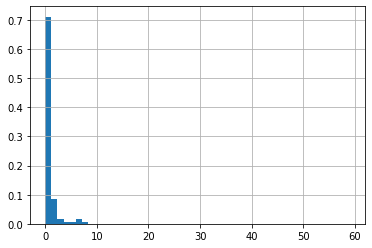

In [227]:
# построим распределение для баннеров
df.query('ad_type == "banner"')['normalized_ecpm_sma'].hist(density=True, bins=50, range=(0, 59))

Как видно на графике, значения больше 8 встречаются крайне редко.

In [228]:
# посчитаем долю строк со значениями больше 8
df.query('ad_type == "banner" and normalized_ecpm_sma > 8')['ad_type'].count() / df.query('ad_type == "banner"')['ad_type'].count()

0.00045344637628941156

Доля таких значений очень мала, это выбросы.

In [229]:
# посмотрим на сами строки с выбросами
df.query('ad_type == "banner" and normalized_ecpm_sma > 8').sample(15)

,profile_id,os_version,device_manufacturer,device_type,device_locale,event_datetime,event_receive_datetime,connection_type,city,ad_type,placement,session_length,revenue,ads_ltv,normalized_ecpm_sma,ad_country_code,network_name
636935,JLutg9n0OqK,12.000,Samsung,phone,en_US,2022-02-05 16:42:51,2022-02-05 16:44:34,cell,Los Angeles,banner,,13,0.005,0.098,8.498,US,AppLovin
636933,JLutg9n0OqK,12.000,Samsung,phone,en_US,2022-02-05 16:42:10,2022-02-05 16:42:10,cell,Los Angeles,banner,,294,0.009,0.009,8.923,US,AppLovin
179307,JLe0DrSE9bs,12.000,Samsung,phone,en_US,2022-02-05 06:38:01,2022-02-05 06:38:33,cell,Boston,banner,,146,0.008,0.355,8.674,US,Google AdMob
495489,JLUe8u1UEuQ,12.000,Samsung,phone,en_US,2022-02-05 05:49:37,2022-02-05 05:49:58,wifi,NaN,banner,,54,0.064,1.263,43.653,US,AppLovin
179296,JLe0DrSE9bs,12.000,Samsung,phone,en_US,2022-02-05 06:36:31,2022-02-05 06:37:18,cell,Boston,banner,,56,0.008,0.310,9.692,US,Google AdMob
495511,JLUe8u1UEuQ,12.000,Samsung,phone,en_US,2022-02-05 05:54:31,2022-02-05 05:54:35,wifi,NaN,banner,,347,0.002,1.579,13.804,US,Google AdMob
634607,JMFK6WfVNRt,12.000,Samsung,phone,en_US,2022-02-07 02:46:10,2022-02-07 02:46:21,wifi,NaN,banner,,715,0.007,0.458,8.062,US,Google AdMob
636944,JLutg9n0OqK,12.000,Samsung,phone,en_US,2022-02-05 16:48:50,2022-02-05 16:48:50,cell,Los Angeles,banner,,372,0.008,0.159,8.240,US,AppLovin
516393,JLyO4NwzTvq,12.000,Samsung,phone,en_US,2022-02-06 01:42:33,2022-02-06 01:43:03,wifi,Corbin,banner,,360,0.007,0.309,20.965,US,Google AdMob
27133,JLprjBZ6Pvw,11.000,Samsung,phone,en_US,2022-02-04 22:31:09,2022-02-04 22:31:10,wifi,Santa Rosa,banner,,55,0.020,0.191,19.758,US,AppLovin


Никаких особых закономерностей в данных нет, но можно отметить, что во всех случаях задержек между показом и получением рекламы практически нет.

<AxesSubplot:>

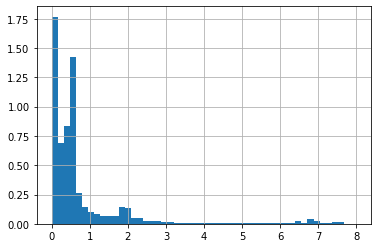

In [230]:
# посмотрим теперь на распределение значений до 8
df.query('ad_type == "banner" and normalized_ecpm_sma < 8')['normalized_ecpm_sma'].hist(density=True, bins=50, range=(0, 8))

На графике есть два пика значений: 0.1 и 0.5. Это наиболее частотные значения еСРМ для баннеров.

In [231]:
# получим числовое описание колонки есрм для полноэкранной рекламы
df.query('ad_type == "int"')['normalized_ecpm_sma'].describe()

count   37610.000
mean       44.177
std        49.048
min         0.346
25%        16.146
50%        25.706
75%        52.769
max       720.058
Name: normalized_ecpm_sma, dtype: float64

<AxesSubplot:>

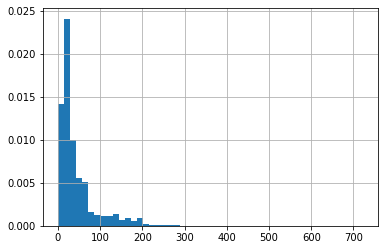

In [232]:
# построим распределение для полноэкранной рекламы
df.query('ad_type == "int"')['normalized_ecpm_sma'].hist(density=True, bins=50, range=(0, 721))

Значения больше 300 встречаются очень редко.

In [233]:
# посчитаем долю строк со значениями больше 300
df.query('ad_type == "int" and normalized_ecpm_sma > 300')['ad_type'].count() / df.query('ad_type == "int"')['ad_type'].count()

0.0031906407870247273

In [234]:
# посчитаем количество таких строк
df.query('ad_type == "int" and normalized_ecpm_sma > 300')['ad_type'].count()

120

И снова доля таких значений очень мала.

In [235]:
# посмотрим на сами строки с выбросами
df.query('ad_type == "int" and normalized_ecpm_sma > 300').sample(15)

,profile_id,os_version,device_manufacturer,device_type,device_locale,event_datetime,event_receive_datetime,connection_type,city,ad_type,placement,session_length,revenue,ads_ltv,normalized_ecpm_sma,ad_country_code,network_name
249338,JLka22uEjJH,12.000,Samsung,phone,en_US,2022-02-04 04:53:57,2022-02-04 04:54:21,wifi,Indianapolis,int,next_level,2779,0.191,1.694,482.334,US,Google AdMob
16604,JLmQMdDt0iv,12.000,Google,phone,en_US,2022-02-04 06:57:31,2022-02-04 06:57:36,wifi,Nashua,int,next_level,1611,0.319,2.552,459.570,US,AppLovin
549801,JLmBDZ2hY6L,12.000,Samsung,phone,en_US,2022-02-07 06:26:40,2022-02-07 06:27:11,cell,Richardson,int,next_level,3933,0.319,3.742,406.414,US,AppLovin
405819,JLk1Nh53w2K,12.000,Samsung,phone,en_US,2022-02-06 16:46:54,2022-02-06 16:46:54,wifi,Rocky Mount,int,next_level,107,0.416,8.726,312.151,US,AppLovin
258235,JL5Tof1j4Ek,11.000,Samsung,phone,en_US,2022-02-06 00:48:05,2022-02-06 00:49:38,wifi,NaN,int,next_level,378,0.367,25.293,333.479,US,AppLovin
751601,JLmL2dPKM0B,11.000,Samsung,phone,en_US,2022-02-04 06:21:36,2022-02-04 06:23:58,wifi,NaN,int,next_level,479,0.336,0.672,336.459,US,AppLovin
405758,JLk1Nh53w2K,12.000,Samsung,phone,en_US,2022-02-06 05:46:04,2022-02-06 05:46:46,wifi,Rocky Mount,int,next_level,1132,0.315,6.763,340.028,US,AppLovin
100551,JLm5yg1rHbm,12.000,Samsung,phone,en_US,2022-02-04 07:30:40,2022-02-04 07:31:02,cell,Cleveland,int,next_level,190,0.429,0.429,428.746,US,AppLovin
520976,JMANPvFDH9q,12.000,Google,phone,en_US,2022-02-06 08:55:13,2022-02-06 08:55:39,wifi,Cincinnati,int,next_level,669,0.277,1.455,345.447,US,AppLovin
380670,JMDwbjQO50b,12.000,Samsung,phone,en_US,2022-02-07 23:50:51,2022-02-07 23:51:27,wifi,NaN,int,replay,103,0.574,9.298,483.168,US,AppLovin


Похоже, что полноэкранная реклама часто всплывает при переходе на новый уровень.

<AxesSubplot:>

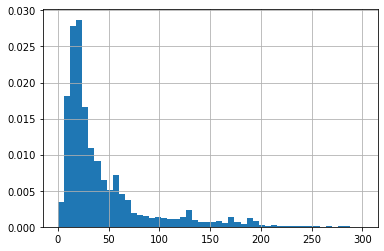

In [236]:
# посмотрим теперь на распределение значений до 300
df.query('ad_type == "int" and normalized_ecpm_sma < 300')['normalized_ecpm_sma'].hist(density=True, bins=50, range=(0, 300))

Пик значений еСРМ для полноэкранной рекламы приходится на 30-40.

In [237]:
# получим числовое описание колонки есрм для rv видео
df.query('ad_type == "rv"')['normalized_ecpm_sma'].describe()

count   6482.000
mean      73.655
std       78.852
min        0.573
25%       28.025
50%       38.813
75%       81.638
max      917.696
Name: normalized_ecpm_sma, dtype: float64

<AxesSubplot:>

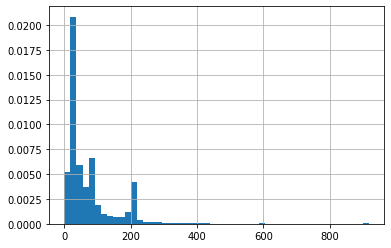

In [238]:
# построим распределение для rv рекламы
df.query('ad_type == "rv"')['normalized_ecpm_sma'].hist(density=True, bins=50, range=(0, 918))

Здесь значения больше 400 встречаются редко.

In [239]:
# посчитаем долю строк со значениями больше 400
df.query('ad_type == "rv" and normalized_ecpm_sma > 400')['ad_type'].count() / df.query('ad_type == "rv"')['ad_type'].count()

0.006942301758716445

In [240]:
# посчитаем количество таких строк 
df.query('ad_type == "rv" and normalized_ecpm_sma > 400')['ad_type'].count()

45

<AxesSubplot:>

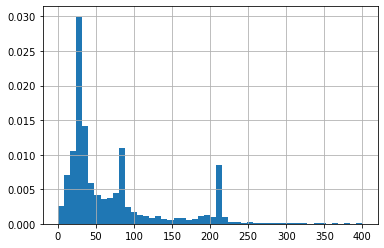

In [241]:
# посмотрим теперь на распределение значений до 400
df.query('ad_type == "rv" and normalized_ecpm_sma < 400')['normalized_ecpm_sma'].hist(density=True, bins=50, range=(0, 400))

Основной пик значений еСРМ для rv рекламы находится на 30.

#### Вывод

Распределение средних еСРМ для полноэкранной рекламы и rv рекламы выглядит похоже, но распределение значений баннеров сильно отличается. Баннеры - самый распространённый формат рекламы, но вместе с тем приносит и самую маленькую прибыль. Распространённость легко объясняется тем, что это самый простой тип рекламы, дешевле стоит и занимает совсем немного места.

### Средние eCPM-ы по городам

In [242]:
# создадим сводную таблицу с количеством показов баннеров по городам
city_banner_pivot = df.query('ad_type == "banner"').pivot_table(index='city', values='profile_id', aggfunc='count').sort_values(by='profile_id', ascending=False)
city_banner_pivot

,profile_id
city,
New York,16801
Minneapolis,12066
Springfield,9769
Houston,9578
Charlotte,9196
...,...
Fremont,1
Kingston,1
Indio,1


В таблице представлено очень много городов, не все из них нужно учитывать при распределении средних еСРМ. Нужно задать порог статистической значимости: города, в которых количество показов менее 1% от общей выборки, будем считать незначимыми и отбросим.

In [243]:
# найдём пороговое значение, равное 1%
df.query('ad_type == "banner"')['city'].count() * 0.01

5081.91

In [244]:
# округлим значение до 5000 и отбросим города, в которых количество показов меньше
city_banner_pivot = city_banner_pivot.query('profile_id >= 5000')
city_banner_pivot

,profile_id
city,
New York,16801
Minneapolis,12066
Springfield,9769
Houston,9578
Charlotte,9196
Chicago,8329
San Antonio,7709
Indianapolis,6768
Kansas City,6741


In [245]:
# создадим сводную таблицу со средними есрм по городам
ecpm_banner_by_city = df.query('ad_type == "banner"').pivot_table(index='city', values='normalized_ecpm_sma')
ecpm_banner_by_city

,normalized_ecpm_sma
city,
Aberdeen,0.338
Abilene,1.154
Addison,0.489
Afton,0.362
Akron,0.377
...,...
Youngstown,1.684
Ypsilanti,0.273
Yukon,0.152


In [246]:
# объединим таблицы
city_banner_pivot['ecpm'] = ecpm_banner_by_city.normalized_ecpm_sma

In [247]:
# отсортируем значения по убыванию есрм
city_banner_pivot = city_banner_pivot.sort_values(by='ecpm', ascending=False)
city_banner_pivot

,profile_id,ecpm
city,,
Spokane,5739,1.565
Indianapolis,6768,1.475
Cleveland,6044,1.278
Dallas,5831,0.988
Houston,9578,0.926
Columbus,5915,0.843
Kansas City,6741,0.834
New York,16801,0.794
Charlotte,9196,0.772


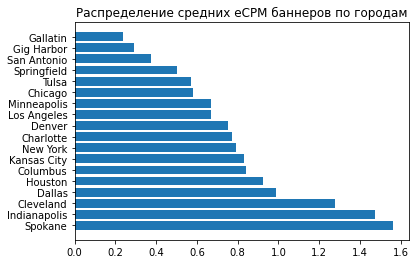

In [248]:
# построим столбчатую диаграмму
plt.barh(city_banner_pivot.index.values, city_banner_pivot.ecpm)
plt.title('Распределение средних еСРМ баннеров по городам')
plt.show()

Топ-3 города, которые приносят самый высокий доход с баннеров:
1. Спокан
2. Индианаполис
3. Кливленд    
    
При этом Индианаполис и Кливленд находятся в соседних штатах на Северо-Востоке США, а Спокан в противоположном конце США, в штате Вашингтон. В целом, в выборке по городам есть перевес в сторону Северо-Востока.

In [249]:
# создадим сводную таблицу с количеством показов полноэкранной рекламы по городам
city_int_pivot = df.query('ad_type == "int"').pivot_table(index='city', values='profile_id', aggfunc='count').sort_values(by='profile_id', ascending=False)
city_int_pivot

,profile_id
city,
Minneapolis,718
New York,652
Charlotte,497
Houston,462
Springfield,363
...,...
Stow,1
Strongsville,1
North Platte,1


In [250]:
# найдём пороговое значение, равное 1%
df.query('ad_type == "int"')['city'].count() * 0.01

238.18

In [251]:
# округлим значение до 200 и отбросим города, в которых количество показов меньше
city_int_pivot = city_int_pivot.query('profile_id >= 200')
city_int_pivot

,profile_id
city,
Minneapolis,718
New York,652
Charlotte,497
Houston,462
Springfield,363
Chicago,347
Cleveland,344
Indianapolis,317
Dallas,307


In [252]:
# создадим сводную таблицу со средними есрм по городам
ecpm_int_by_city = df.query('ad_type == "int"').pivot_table(index='city', values='normalized_ecpm_sma')
ecpm_int_by_city

,normalized_ecpm_sma
city,
Aberdeen,15.509
Abilene,54.667
Afton,35.250
Akron,66.129
Alameda,22.279
...,...
Youngstown,65.252
Ypsilanti,76.717
Yukon,14.947


In [253]:
# объединим таблицы
city_int_pivot['ecpm'] = ecpm_int_by_city.normalized_ecpm_sma

In [254]:
# отсортируем значения по убыванию есрм
city_int_pivot = city_int_pivot.sort_values(by='ecpm', ascending=False)
city_int_pivot

,profile_id,ecpm
city,,
Indianapolis,317,89.467
Cleveland,344,67.699
Columbus,272,56.223
Los Angeles,281,54.525
Kansas City,243,48.071
New York,652,45.879
Denver,286,44.340
Detroit,218,43.024
Dallas,307,42.055


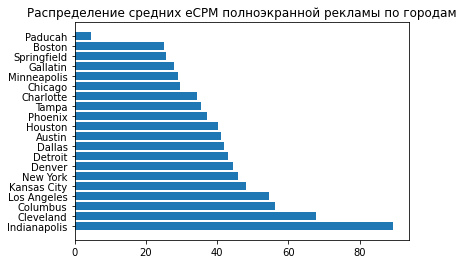

In [255]:
# построим столбчатую диаграмму
plt.barh(city_int_pivot.index.values, city_int_pivot.ecpm)
plt.title('Распределение средних еСРМ полноэкранной рекламы по городам')
plt.show()

Снова Индианаполис и Кливленд оказались в топе самых доходных по показателям еСРМ. Остальные города уже не так сильно отделяются друг от друга. Здесь так же преобладает Северо-Восток США.   
   
Топ-3:
1. Индианаполис
2. Кливленд
3. Колумбус

In [256]:
# создадим сводную таблицу с количеством показов rv рекламы по городам
city_rv_pivot = df.query('ad_type == "rv"').pivot_table(index='city', values='profile_id', aggfunc='count').sort_values(by='profile_id', ascending=False)
city_rv_pivot

,profile_id
city,
Minneapolis,196
Paducah,161
New York,131
Robinson,130
Houston,97
...,...
Lawrence,1
Lewisburg,1
Lompoc,1


In [257]:
# найдём пороговое значение, равное 1%
df.query('ad_type == "rv"')['city'].count() * 0.01

43.62

In [258]:
# округлим значение до 40 и отбросим города, в которых количество показов меньше
city_rv_pivot = city_rv_pivot.query('profile_id >= 40')
city_rv_pivot

,profile_id
city,
Minneapolis,196
Paducah,161
New York,131
Robinson,130
Houston,97
Greenville,90
Savannah,75
Birmingham,65
Oklahoma City,65


In [259]:
# создадим сводную таблицу со средними есрм по городам
ecpm_rv_by_city = df.query('ad_type == "rv"').pivot_table(index='city', values='normalized_ecpm_sma')
ecpm_rv_by_city

,normalized_ecpm_sma
city,
Aberdeen,19.039
Abilene,53.493
Akron,171.070
Alameda,80.705
Albany,76.644
...,...
York,28.240
Youngstown,81.440
Ypsilanti,80.640


In [260]:
# объединим таблицы
city_rv_pivot['ecpm'] = ecpm_rv_by_city.normalized_ecpm_sma

In [261]:
# отсортируем значения по убыванию есрм
city_rv_pivot = city_rv_pivot.sort_values(by='ecpm', ascending=False)
city_rv_pivot

,profile_id,ecpm
city,,
Oklahoma City,65,148.020
Houston,97,131.229
Cleveland,59,130.555
Rockford,53,123.367
Indianapolis,41,123.230
Columbus,52,110.532
Los Angeles,40,102.322
New York,131,77.942
Dallas,40,77.063


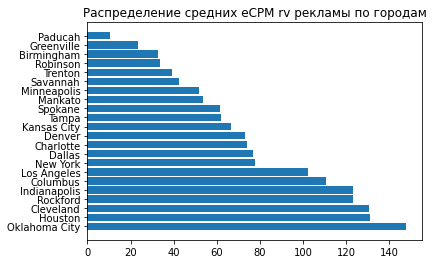

In [262]:
# построим столбчатую диаграмму
plt.barh(city_rv_pivot.index.values, city_rv_pivot.ecpm)
plt.title('Распределение средних еСРМ rv рекламы по городам')
plt.show()

Здесь можно выделить 7 лидеров с самыми доходными rv рекламами:
1. Оклахома-Сити
2. Хьюстон
3. Кливленд
4. Рокфорд
5. Индианаполис
6. Колумбус
7. Лос-Анджелес   
   
Здесь на передний план вышла средняя часть США, однако, Индианаполис и Кливленд тоже попали в топ.

#### Вывод

В этом разделе мы изучили распределение средних еСРМ по городам для каждого формата рекламы. Но прежде, чем анализировать данные, задали порог статистической значимости: города, в которых количество показов менее 1% от общей выборки, считаем незначимыми и отбрасываем.
- **Баннеры**  
Топ-3 города, которые приносят самый высокий доход с баннеров:
1. Спокан
2. Индианаполис
3. Кливленд    
    
При этом Индианаполис и Кливленд находятся в соседних штатах на Северо-Востоке США, а Спокан в противоположном конце США, в штате Вашингтон. В целом, в выборке по городам есть перевес в сторону Северо-Востока.   
    
- **Полноэкранная реклама**  
Снова Индианаполис и Кливленд оказались в топе самых доходных по показателям еСРМ. Остальные города уже не так сильно отделяются друг от друга. Здесь так же преобладает Северо-Восток США.   
   
Топ-3:
1. Индианаполис
2. Кливленд
3. Колумбус
    
- **RV реклама**  
Здесь можно выделить 7 лидеров с самыми доходными rv рекламами:
1. Оклахома-Сити
2. Хьюстон
3. Кливленд
4. Рокфорд
5. Индианаполис
6. Колумбус
7. Лос-Анджелес   
   
Здесь на передний план вышла средняя часть США, однако, Индианаполис и Кливленд тоже попали в топ.  
   
Т.о., города Индианаполис и Кливленд - общие для всех трёх выборок.

### Средние еСРМ-ы по версиям ОС

In [263]:
# посмотрим количество показов баннеров по версиям ОС
df.query('ad_type == "banner"').groupby('os_version')['profile_id'].count()

os_version
7.000       3832
9.000      63361
10.000    143762
11.000    196185
12.000    387982
Name: profile_id, dtype: int64

Получается, что чем новее версия ОС, тем больше показов.

In [264]:
# создадим сводную таблицу с есрм баннеров по версиям ОС
os_banner_pivot = df.query('ad_type == "banner"').pivot_table(index='os_version', values='normalized_ecpm_sma').sort_values(by='os_version', ascending=False)
os_banner_pivot

,normalized_ecpm_sma
os_version,
12.000,0.977
11.000,0.633
10.000,0.624
9.000,0.572
7.000,0.308


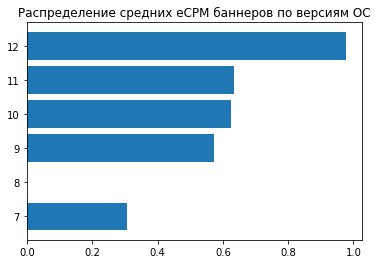

In [265]:
# построим столбчатую диаграмму
plt.barh(os_banner_pivot.index.values, os_banner_pivot.normalized_ecpm_sma)
plt.title('Распределение средних еСРМ баннеров по версиям ОС')
plt.show()

Самая новая 12-я версия ОС показывает сам высокий еСРМ, остальные распределяются примерно одинаково, у 7-й показатель наименьший.

In [266]:
# посмотрим количество показов полноэкранной рекламы по версиям ОС
df.query('ad_type == "int"').groupby('os_version')['profile_id'].count()

os_version
7.000       199
9.000      2906
10.000     6144
11.000    10862
12.000    16619
Name: profile_id, dtype: int64

Здесь тоже с увеличением версии ОС, увеличивается и количество показов.

In [267]:
# создадим сводную таблицу с количеством показов полноэкранной рекламы по версиям ОС
os_int_pivot = df.query('ad_type == "int"').pivot_table(index='os_version', values='normalized_ecpm_sma').sort_values(by='os_version', ascending=False)
os_int_pivot

,normalized_ecpm_sma
os_version,
12.000,51.536
11.000,41.195
10.000,38.273
9.000,32.270
7.000,47.369


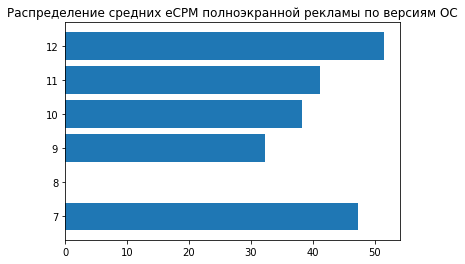

In [268]:
# построим столбчатую диаграмму
plt.barh(os_int_pivot.index.values, os_int_pivot.normalized_ecpm_sma)
plt.title('Распределение средних еСРМ полноэкранной рекламы по версиям ОС')
plt.show()

Здесь лидером так же является 12-я версия ОС, но и 7-я отстаёт не намного. Наименьший показатель у 9-й.

In [269]:
# посмотрим количество показов rv рекламы по версиям ОС
df.query('ad_type == "rv"').groupby('os_version')['profile_id'].count()

os_version
7.000       26
9.000      395
10.000     965
11.000    2010
12.000    2986
Name: profile_id, dtype: int64

Чем больше версия ОС, тем больше показов. Скорей всего, на более новых версиях сидит большее количество пользователей, поэтому везде похожее распределение.

In [270]:
# создадим сводную таблицу с количеством показов rv рекламы по версиям ОС
os_rv_pivot = df.query('ad_type == "rv"').pivot_table(index='os_version', values='normalized_ecpm_sma').sort_values(by='os_version', ascending=False)
os_rv_pivot

,normalized_ecpm_sma
os_version,
12.000,89.904
11.000,60.886
10.000,60.665
9.000,56.712
7.000,83.373


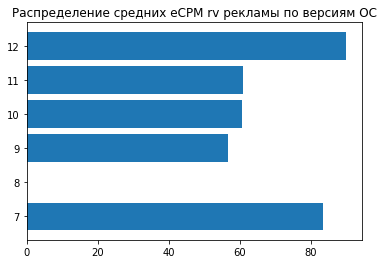

In [271]:
# построим столбчатую диаграмму
plt.barh(os_rv_pivot.index.values, os_rv_pivot.normalized_ecpm_sma)
plt.title('Распределение средних еСРМ rv рекламы по версиям ОС')
plt.show()

Ситуация похожа на ту, что с полноэкранной рекламой: наибольший показатель у 12-й версии, затем 7-я, остальные распределяются примерно одинаково.

#### Вывод

В этом разделе мы изучили распределение средних еСРМ по версиям ОС для каждого формата рекламы. Для всех трёх выборок верно то, что чем новее версия ОС, тем больше показов. Это, вероятно, связано с тем, что большинство пользователей предпочитают более новые версии.  

- **Баннеры**  
Самая новая 12-я версия ОС показывает сам высокий еСРМ, остальные распределяются примерно одинаково, у 7-й показатель наименьший.  
  
1. 12
2. 9, 10, 11
3. 7
- **Полноэкранная реклама**  
Здесь лидером так же является 12-я версия ОС, но и 7-я отстаёт не намного. Наименьший показатель у 9-й.  
  
1. 12
2. 7
3. 8, 11
4. 9
- **RV реклама**  
Ситуация похожа на ту, что с полноэкранной рекламой: наибольший показатель у 12-й версии, затем 7-я, остальные распределяются примерно одинаково.  
  
1. 12
2. 7
3. 9, 10, 11

### Суммарные доходы по городам

In [272]:
# посмотрим суммарный доход от каждого формата рекламы
df.pivot_table(index='ad_type', values='revenue', aggfunc='sum')

,revenue
ad_type,
banner,607.179
int,1361.889
rv,421.662


Полноэкранная реклама приносит в сумме самый большой доход.

In [273]:
# построим сводную таблицу с суммарными доходами от баннеров по городам
banner_revenue = df.query('ad_type == "banner"').pivot_table(index='city', values='revenue', aggfunc='sum')
banner_revenue

,revenue
city,
Aberdeen,0.031
Abilene,0.043
Addison,0.000
Afton,0.110
Akron,0.132
...,...
Youngstown,0.432
Ypsilanti,0.424
Yukon,0.164


In [274]:
# объединим полученную таблицу с отфильтрованными городами
city_banner_pivot['revenue'] = banner_revenue.revenue
city_banner_pivot = city_banner_pivot.sort_values(by='revenue', ascending=False)
city_banner_pivot

,profile_id,ecpm,revenue
city,,,
New York,16801,0.794,12.709
Indianapolis,6768,1.475,9.789
Spokane,5739,1.565,8.862
Houston,9578,0.926,8.665
Minneapolis,12066,0.668,7.629
Cleveland,6044,1.278,7.565
Charlotte,9196,0.772,6.889
Dallas,5831,0.988,5.592
Kansas City,6741,0.834,5.582


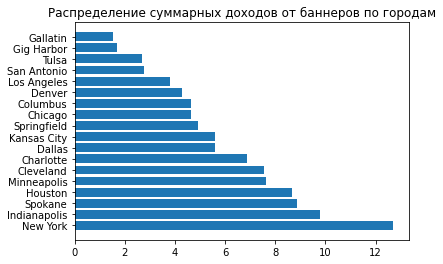

In [275]:
# построим столбчатую диаграмму
plt.barh(city_banner_pivot.index.values, city_banner_pivot.revenue)
plt.title('Распределение суммарных доходов от баннеров по городам')
plt.show()

Самый высокий доход в сумме баннеры приносят в Нью-Йорке, следом идут остальные города, ненамного отставая друг от друга, замыкает Галлатин.

In [276]:
# построим сводную таблицу с суммарными доходами от полноэкранной рекламы по городам
int_revenue = df.query('ad_type == "int"').pivot_table(index='city', values='revenue', aggfunc='sum')
int_revenue

,revenue
city,
Aberdeen,0.081
Abilene,0.402
Afton,0.727
Akron,1.680
Alameda,0.020
...,...
Youngstown,0.627
Ypsilanti,2.771
Yukon,0.638


In [277]:
# объединим полученную таблицу с отфильтрованными городами
city_int_pivot['revenue'] = int_revenue.revenue
city_int_pivot = city_int_pivot.sort_values(by='revenue', ascending=False)
city_int_pivot

,profile_id,ecpm,revenue
city,,,
New York,652,45.879,25.674
Indianapolis,317,89.467,21.534
Cleveland,344,67.699,18.113
Minneapolis,718,28.940,17.286
Charlotte,497,34.483,14.941
Houston,462,40.197,14.498
Columbus,272,56.223,12.373
Los Angeles,281,54.525,12.182
Dallas,307,42.055,10.198


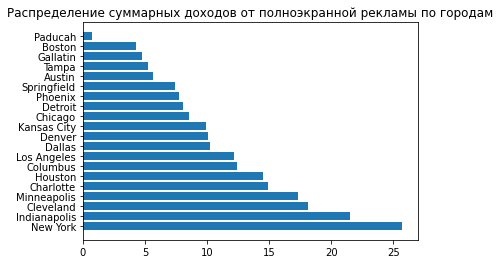

In [278]:
# построим столбчатую диаграмму
plt.barh(city_int_pivot.index.values, city_int_pivot.revenue)
plt.title('Распределение суммарных доходов от полноэкранной рекламы по городам')
plt.show()

Похожая ситуация: Нью-Йорк на первом месте, следом Индианаполис и все остальные города, замыкает Падука.

In [279]:
# построим сводную таблицу с суммарными доходами от rv рекламы по городам
rv_revenue = df.query('ad_type == "rv"').pivot_table(index='city', values='revenue', aggfunc='sum')
rv_revenue

,revenue
city,
Aberdeen,0.022
Abilene,0.107
Akron,1.656
Alameda,0.081
Albany,0.163
...,...
York,0.028
Youngstown,0.081
Ypsilanti,0.081


In [280]:
# объединим полученную таблицу с отфильтрованными городами
city_rv_pivot['revenue'] = rv_revenue.revenue
city_rv_pivot = city_rv_pivot.sort_values(by='revenue', ascending=False)
city_rv_pivot

,profile_id,ecpm,revenue
city,,,
Houston,97,131.229,11.389
Minneapolis,196,51.797,9.320
New York,131,77.942,9.072
Oklahoma City,65,148.020,8.045
Cleveland,59,130.555,6.798
Indianapolis,41,123.230,5.356
Rockford,53,123.367,5.207
Columbus,52,110.532,5.164
Robinson,130,33.750,3.967


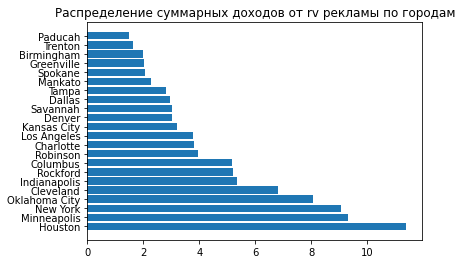

In [281]:
# построим столбчатую диаграмму
plt.barh(city_rv_pivot.index.values, city_rv_pivot.revenue)
plt.title('Распределение суммарных доходов от rv рекламы по городам')
plt.show()

Топ-5 городов с самым высоким суммарным доходом от rv рекламы:
1. Хьюстон (Техас)
2. Миннеаполис (Миннесота)
3. Нью-Йорк
4. Оклахома-Сити (Оклахома)
5. Кливленд (Огайо)

#### Вывод

В этом разделе мы изучили распределение суммарных доходов по городам для каждого формата рекламы. Если посчитать суммарные доходы в целом по типам рекламы, то получается, что полноэкранная реклама приносит в сумме самый большой доход. Рейтинг:  
1. Полноэкранная реклама
2. Баннеры
3. RV реклама
Такое распределение может быть связано с тем, что на полноэкранную рекламу чаще кликают случайно, т.к. она занимает много места, баннеры больше всего распространены.   

  
- **Баннеры**  
Самый высокий доход в сумме баннеры приносят в Нью-Йорке, следом идут остальные города, ненамного отставая друг от друга, замыкает Галлатин.
1. Нью-Йорк
2. Индианаполис
3. Спокан
4. Хьюстон
  
- **Полноэкранная реклама**  
Похожая ситуация: Нью-Йорк на первом месте, следом Индианаполис и все остальные города, замыкает Падука.
1. Нью-Йорк
2. Индианаполис
3. Кливленд
4. Миннеаполис
  
- **RV реклама**  
Топ-5 городов с самым высоким суммарным доходом от rv рекламы:
1. Хьюстон (Техас)
2. Миннеаполис (Миннесота)
3. Нью-Йорк
4. Оклахома-Сити (Оклахома)
5. Кливленд (Огайо)

### Суммарные доходы по версиям ОС

In [282]:
# создадим сводную таблицу с суммарными доходами баннеров по версиям ОС
os_banner_revenue = df.query('ad_type == "banner"').pivot_table(index='os_version', values='revenue', aggfunc='sum').sort_values(by='os_version', ascending=False)
os_banner_revenue

,revenue
os_version,
12.000,363.489
11.000,116.293
10.000,85.003
9.000,34.820
7.000,1.066


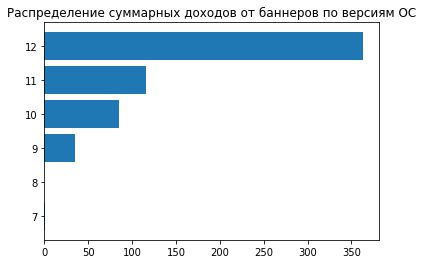

In [283]:
# построим столбчатую диаграмму
plt.barh(os_banner_revenue.index.values, os_banner_revenue.revenue)
plt.title('Распределение суммарных доходов от баннеров по версиям ОС')
plt.show()

Самый большой суммарный доход от баннеров приносит 12-я версия ОС, остальные намного меньше и 7-я почти совсем не приносит доход.

In [284]:
# создадим сводную таблицу с суммарными доходами полноэкранной рекламы по версиям ОС
os_int_revenue = df.query('ad_type == "int"').pivot_table(index='os_version', values='revenue', aggfunc='sum').sort_values(by='os_version', ascending=False)
os_int_revenue

,revenue
os_version,
12.000,704.497
11.000,363.571
10.000,191.795
9.000,78.476
7.000,7.814


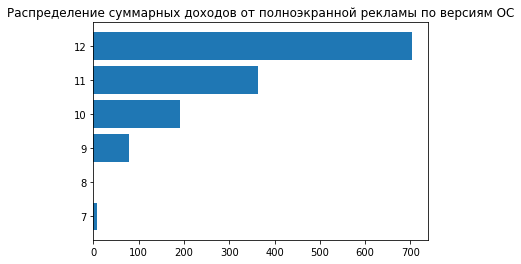

In [285]:
# построим столбчатую диаграмму
plt.barh(os_int_revenue.index.values, os_int_revenue.revenue)
plt.title('Распределение суммарных доходов от полноэкранной рекламы по версиям ОС')
plt.show()

Ситуация похожая: самый высокий суммарный доход приходится на 12-ю версию, остальные меньше и 7-я почти в ноль.

In [286]:
# создадим сводную таблицу с суммарными доходами rv рекламы по версиям ОС
os_rv_revenue = df.query('ad_type == "rv"').pivot_table(index='os_version', values='revenue', aggfunc='sum').sort_values(by='os_version', ascending=False)
os_rv_revenue

,revenue
os_version,
12.000,237.593
11.000,107.292
10.000,51.470
9.000,19.810
7.000,2.071


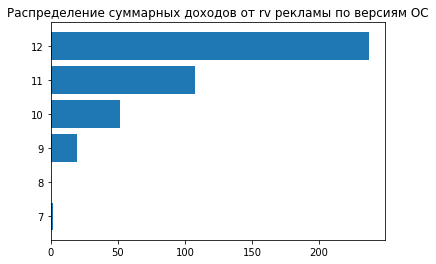

In [287]:
# построим столбчатую диаграмму
plt.barh(os_rv_revenue.index.values, os_rv_revenue.revenue)
plt.title('Распределение суммарных доходов от rv рекламы по версиям ОС')
plt.show()

И здесь такое же ступенчатое распределение, как и в двух предыдущих случаях.

#### Вывод

В этом разделе мы изучили распределение суммарного дохода по версиям ОС для каждого формата рекламы. Во всех трёх случаях распределение примерно одинаковое: чем меньше версия ОС, тем меньше доход, причём 12-я версия сильно опережает остальные.

### Сравнительный анализ

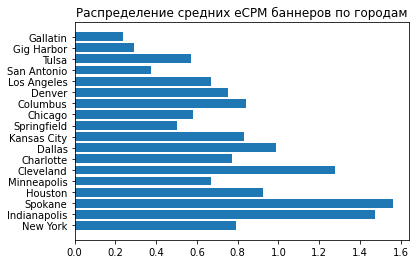

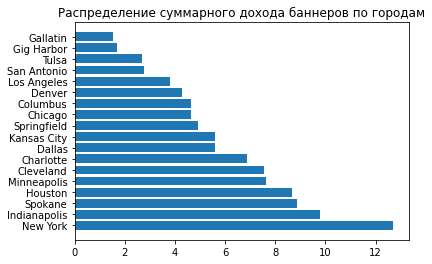

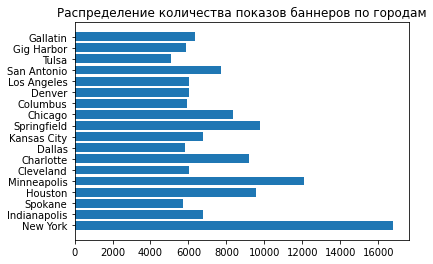

In [288]:
# сравним графики еСРМ и суммарного дохода для баннеров по городам
plt.barh(city_banner_pivot.index.values, city_banner_pivot.ecpm)
plt.title('Распределение средних еСРМ баннеров по городам')
plt.show()
plt.barh(city_banner_pivot.index.values, city_banner_pivot.revenue)
plt.title('Распределение суммарного дохода баннеров по городам')
plt.show()
plt.barh(city_banner_pivot.index.values, city_banner_pivot.profile_id)
plt.title('Распределение количества показов баннеров по городам')
plt.show()

По графику можно заметить, что в Спокане, Индианаполисе и Кливленде самые высокие еСРМ по баннерам и, даже несмотря на небольшое количество показов рекламы, Индианаполис и Спокан на 2-м и 3-м месте по суммарному доходу. Возможно, есть смысл увеличить количество показов в этих трёх городах, чтобы получить больший доход.   
    
В Нью-Йорке показатель еСРМ не очень большой, но за счёт большого количества показов суммарный доход самый высокий.
    
Миннеаполис занимает 2-е место по количеству показов, но еСРМ у него даже меньше, чем у Нью-Йорка. Получается, что это не самая выгодная точка.    
     
Так же стоит обратить внимание на Даллас: он является одним из городов с наименьшим количеством показов, но при этом имеет довольно высокий показатель еСРМ и мог бы принести больший доход, если увеличить количество показов.

In [289]:
# добавим в таблицу еСРМ по версиям ОС количество показов баннеров b суммарный доход
os_banner_pivot['count'] = df.query('ad_type == "banner"').groupby('os_version')['profile_id'].count()
os_banner_pivot['revenue'] = os_banner_revenue.revenue
os_banner_pivot

,normalized_ecpm_sma,count,revenue
os_version,,,
12.000,0.977,387982,363.489
11.000,0.633,196185,116.293
10.000,0.624,143762,85.003
9.000,0.572,63361,34.820
7.000,0.308,3832,1.066


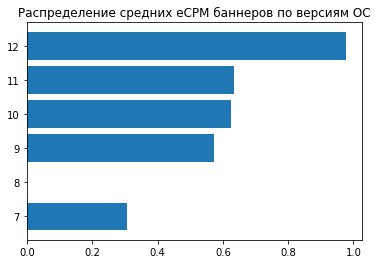

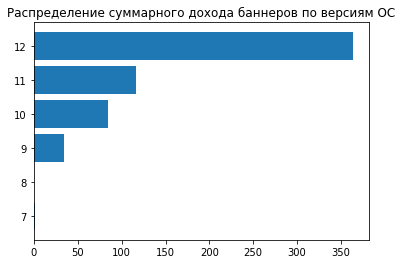

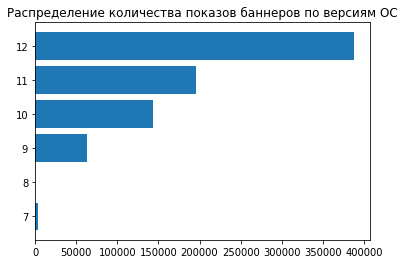

In [290]:
# сравним графики еСРМ и суммарного дохода для баннеров по версиям ОС
plt.barh(os_banner_pivot.index.values, os_banner_pivot.normalized_ecpm_sma)
plt.title('Распределение средних еСРМ баннеров по версиям ОС')
plt.show()
plt.barh(os_banner_pivot.index.values, os_banner_pivot.revenue)
plt.title('Распределение суммарного дохода баннеров по версиям ОС')
plt.show()
plt.barh(os_banner_pivot.index.values, os_banner_pivot['count'])
plt.title('Распределение количества показов баннеров по версиям ОС')
plt.show()

На 12-й версии реклама показывается чаще всего и это оправданно: самый высокий показатель еСРМ и, как следствие, суммарный доход.  
   
У 9-11 версий примерно одинаковый еСРМ и суммарный доход зависит только от количества показов.   
   
7-я версия закономерно оказывается в самом низу списка как по показателю еСРМ, так и по суммарному доходу, потому и показов меньше.

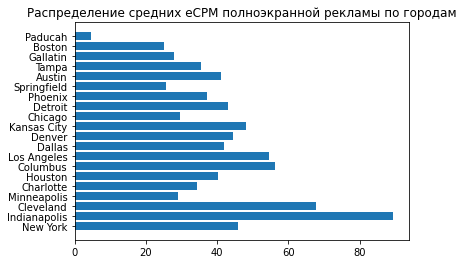

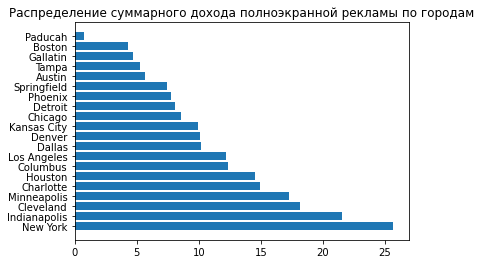

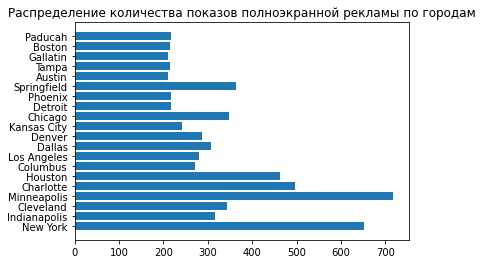

In [291]:
# сравним графики еСРМ и суммарного дохода для полноэкранной рекламы по городам
plt.barh(city_int_pivot.index.values, city_int_pivot.ecpm)
plt.title('Распределение средних еСРМ полноэкранной рекламы по городам')
plt.show()

plt.barh(city_int_pivot.index.values, city_int_pivot.revenue)
plt.title('Распределение суммарного дохода полноэкранной рекламы по городам')
plt.show()

plt.barh(city_int_pivot.index.values, city_int_pivot.profile_id)
plt.title('Распределение количества показов полноэкранной рекламы по городам')
plt.show()

В первую очередь смотрим на города с самыми высокими еСРМ: снова Индианаполис и Кливленд, которые могли бы принести больше дохода, если будет больше показов.   
   
И снова Миннеаполис с самым большим количеством показов, но низким показателем еСРМ.
   
У Нью-Йорка стабильно средний еСРМ и за счёт количества большой суммарный доход.

In [292]:
# добавим в таблицу еСРМ по версиям ОС количество показов полноэкранной рекламы и суммарный доход
os_int_pivot['count'] = df.query('ad_type == "int"').groupby('os_version')['profile_id'].count()
os_int_pivot['revenue'] = os_int_revenue.revenue
os_int_pivot

,normalized_ecpm_sma,count,revenue
os_version,,,
12.000,51.536,16619,704.497
11.000,41.195,10862,363.571
10.000,38.273,6144,191.795
9.000,32.270,2906,78.476
7.000,47.369,199,7.814


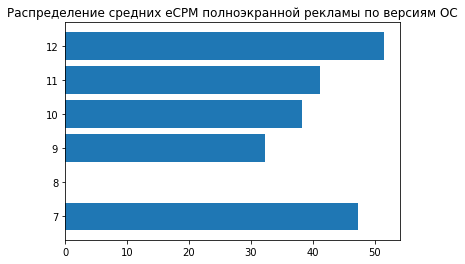

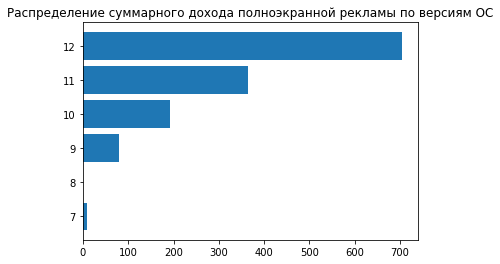

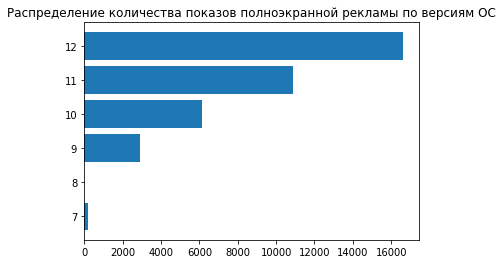

In [293]:
# сравним графики еСРМ и суммарного дохода для полноэкранной рекламы по версиям ОС
plt.barh(os_int_pivot.index.values, os_int_pivot.normalized_ecpm_sma)
plt.title('Распределение средних еСРМ полноэкранной рекламы по версиям ОС')
plt.show()

plt.barh(os_int_pivot.index.values, os_int_pivot.revenue)
plt.title('Распределение суммарного дохода полноэкранной рекламы по версиям ОС')
plt.show()

plt.barh(os_int_pivot.index.values, os_int_pivot['count'])
plt.title('Распределение количества показов полноэкранной рекламы по версиям ОС')
plt.show()

А вот здесь интересно посмотреть на 7-ю версию ОС, где оказался довольно высокий еСРМ, но при этом маленькое количество показов практически не приносит доход.  
   
С остальными версиями распределение вполне логичное и закономерное.

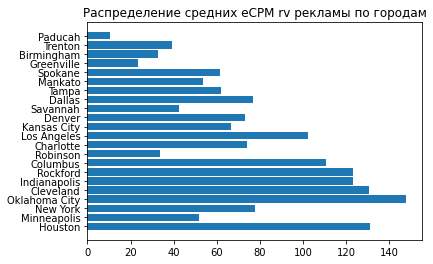

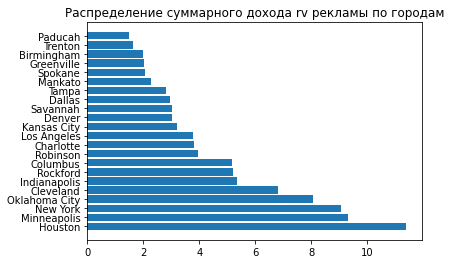

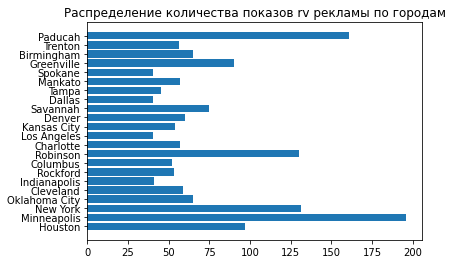

In [294]:
# сравним графики еСРМ и суммарного дохода для rv рекламы по городам
plt.barh(city_rv_pivot.index.values, city_rv_pivot.ecpm)
plt.title('Распределение средних еСРМ rv рекламы по городам')
plt.show()
plt.barh(city_rv_pivot.index.values, city_rv_pivot.revenue)
plt.title('Распределение суммарного дохода rv рекламы по городам')
plt.show()
plt.barh(city_rv_pivot.index.values, city_rv_pivot.profile_id)
plt.title('Распределение количества показов rv рекламы по городам')
plt.show()

Оклахома-Сити, имея самый высокий еСРМ, мало показывает рекламу, но даже так приносит большой доход.
   
Похожая ситуация с Кливлендом: еСРМ высокий, а показов мало.
   
Интересно посмотреть на Хьюстон: у него и еСРМ высокий, и суммарный доход самый высокий. Количество показов не намного больше, чем в предыдущих случаях, а результативная разница существенная.  
   
С Миннеаполисом ситуация понятная: примерно то же самое, что и в предыдущих случаях, а вот Падука выбивается из общей картины: судя по всему там есть активные пользователи, которые часто смотрят рекламу за игровые ресурсы, но это приносит мало дохода т.к. еСРМ самый низкий.

In [295]:
# добавим в таблицу еСРМ по версиям ОС количество показов rv рекламы и суммарный доход
os_rv_pivot['count'] = df.query('ad_type == "rv"').groupby('os_version')['profile_id'].count()
os_rv_pivot['revenue'] = os_rv_revenue.revenue
os_rv_pivot

,normalized_ecpm_sma,count,revenue
os_version,,,
12.000,89.904,2986,237.593
11.000,60.886,2010,107.292
10.000,60.665,965,51.470
9.000,56.712,395,19.810
7.000,83.373,26,2.071


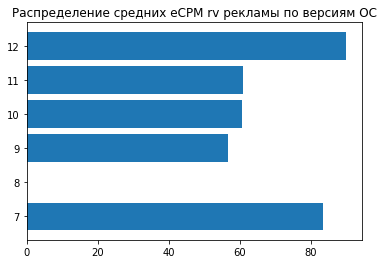

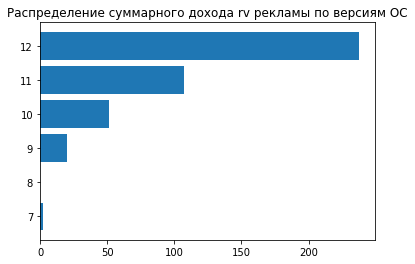

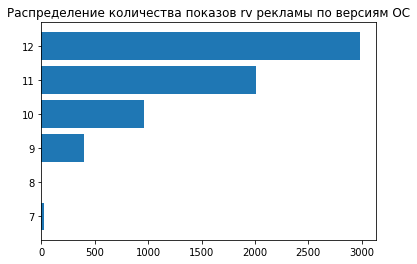

In [296]:
# сравним графики еСРМ и суммарного дохода для полноэкранной рекламы по версиям ОС
plt.barh(os_rv_pivot.index.values, os_rv_pivot.normalized_ecpm_sma)
plt.title('Распределение средних еСРМ rv рекламы по версиям ОС')
plt.show()
plt.barh(os_rv_pivot.index.values, os_rv_pivot.revenue)
plt.title('Распределение суммарного дохода rv рекламы по версиям ОС')
plt.show()
plt.barh(os_rv_pivot.index.values, os_rv_pivot['count'])
plt.title('Распределение количества показов rv рекламы по версиям ОС')
plt.show()

То же самое наблюдение, что и с полноэкранной рекламой.

#### Вывод

В этом разделе мы изучили, как соотносятся средние еСРМ, суммарный доход и количество показов для каждого формата рекламы по городам и версиям ОС.  
  
- **Баннеры**  
1. *по городам*   
В Спокане, Индианаполисе и Кливленде самые высокие еСРМ по баннерам и, даже несмотря на небольшое количество показов рекламы, Индианаполис и Спокан на 2-м и 3-м месте по суммарному доходу. Возможно, есть смысл увеличить количество показов в этих трёх городах, чтобы получить больший доход.   
    
В Нью-Йорке показатель еСРМ не очень большой, но за счёт большого количества показов суммарный доход самый высокий.
    
Миннеаполис занимает 2-е место по количеству показов, но еСРМ у него даже меньше, чем у Нью-Йорка. Получается, что это не самая выгодная точка.    
     
Так же стоит обратить внимание на Даллас: он является одним из городов с наименьшим количеством показов, но при этом имеет довольно высокий показатель еСРМ и мог бы принести больший доход, если увеличить количество показов.

2. *по версиям ОС*  
На 12-й версии реклама показывается чаще всего и это оправданно: самый высокий показатель еСРМ и, как следствие, суммарный доход.  
   
У 9-11 версий примерно одинаковый еСРМ и суммарный доход зависит только от количества показов.   
   
7-я версия закономерно оказывается в самом низу списка как по показателю еСРМ, так и по суммарному доходу, потому и показов меньше.
  
- **Полноэкранная реклама**  
1. *по городам*  
В первую очередь смотрим на города с самыми высокими еСРМ: снова Индианаполис и Кливленд, которые могли бы принести больше дохода, если будет больше показов.   
   
И снова Миннеаполис с самым большим количеством показов, но низким показателем еСРМ.
   
У Нью-Йорка стабильно средний еСРМ и за счёт количества большой суммарный доход.

2. *по версиям ОС*  
А вот здесь интересно посмотреть на 7-ю версию ОС, где оказался довольно высокий еСРМ, но при этом маленькое количество показов практически не приносит доход.  
   
С остальными версиями распределение вполне логичное и закономерное.
  
- **RV реклама**  
1. *по городам*  
Оклахома-Сити, имея самый высокий еСРМ, мало показывает рекламу, но даже так приносит большой доход.
   
Похожая ситуация с Кливлендом: еСРМ высокий, а показов мало.
   
Интересно посмотреть на Хьюстон: у него и еСРМ высокий, и суммарный доход самый высокий. Количество показов не намного больше, чем в предыдущих случаях, а результативная разница существенная.  
   
С Миннеаполисом ситуация понятная: примерно то же самое, что и в предыдущих случаях, а вот Падука выбивается из общей картины: судя по всему там есть активные пользователи, которые часто смотрят рекламу за игровые ресурсы, но это приносит мало дохода т.к. еСРМ самый низкий.
  
2. *по версиям ОС*  
То же самое наблюдение, что и с полноэкранной рекламой.

## Общий вывод

Заказчик этого исследования — геймдев-компания, зарабатывающая на показе рекламы.  
   
Есть несколько форматов:
- int – полноэкранная реклама; 
- banner – горизонтальный баннер, висит внизу экрана пока юзер играет; 
- rv – видео, которое юзер смотрит по желанию и за просмотр получает монетки или др. ресурсы. 
Информация о каждом показе отправляется в аналитику и содержит доход от показа, формат показанной рекламы, рекламную сеть от которой был показ и др.
  
**Задача:** провести исследование показов рекламы с целью понять на сколько отличается eCPM в зависимости от географии (города) юзера, версии ОС и других параметров. Интересны любые инсайты и находки по eCPM-ам.  
  
В нашем распоряжении данные, которые содержат информацию о показах рекламы для юзеров США.  
   
   
**РАЗДЕЛ 1. ОБЗОР ДАННЫХ**  
В нашем датасете 860079 строк и 33 колонки. Изначально было 16 колонок: колонку `event_json` преобразовали в словарь и разбили на дополнительные колонки.  
В данных имеются пропуски и несоответствие типов данных.  
   
**РАЗДЕЛ 2. ПРЕДОБРАБОТКА ДАННЫХ**   
  
***2.1 Проверка типов данных***  
   
В этом разделе:  
- в колонках `event_datetime` и `event_receive_datetime` поменяли тип данных на datetime
- в колонке `os_version` поменяли тип данных на числовой   
    
***2.2 Изучение пропусков***   
   
В этом разделе изучили пропуски в данных и приняли решение 
- удалить строки с пропущенным `profile_id`, т.к. наличие идентификационного номера пользователя обязательно
- оставить данные с пропусками в `operator_name`, `os_version` и `city`, т.к. они содержат много другой полезной информации
- больше всего пропусков обнаружено в колонке `city`: их количество - 323708   
   
***2.3 Изучение категориальных значений***   
   
В этом разделе мы изучили все категориальные значения и удалили ненужные для дальнейшего исследования колонки. Выявленные закономерности:
- самое распространённое устройство, с которого играют - Samsung
- с телефона играют чаще, чем с планшета
- реклама показывается, в основном, англоязычным пользователям, но так же корейцам, французам и китайцам
- самый распространнный оператор - Verizon
- больше всего пользователей из Нью-Йорка и Миннеаполиса
- реклама чаще всего показывается в свободном месте, чуть реже при переходе на новый уровень, и ещё реже в других местах
- реклама была показана чаще всего в США, иногда в Индонезии, Франции, Германии, Канаде, Корее, Великобритании, Египте и Мексике
- самая распространённая рекламная сеть - Google AdMob   
    
***2.4 Изучение количественных значений***   
   
В этом разделе мы изучили количественные значения, обнаружили колонки с дублирующимимся значениями и удалили те колонки, которые не будем использовать в дальнейшем исследовании. Кстати некоторые колонки, представленные числовыми значениями, по своей сути являются категориальными, например, версия операционной системы. Строк-дубликатов в данных не обнаружено.   
   
**РАЗДЕЛ 3. ИССЛЕДОВАТЕЛЬСКИЙ АНАЛИЗ ДАННЫХ***  
   
***3.1 Распределение средних еСРМ-ов юзеров***  
   
Распределение средних еСРМ для полноэкранной рекламы и rv рекламы выглядит похоже, но распределение значений баннеров сильно отличается. Баннеры - самый распространённый формат рекламы, но вместе с тем приносит и самую маленькую прибыль. Распространённость легко объясняется тем, что это самый простой тип рекламы, дешевле стоит и занимает совсем немного места.   
   
***3.2 Средние еСРМ-ы по городам***   
   
В этом разделе мы изучили распределение средних еСРМ по городам для каждого формата рекламы. Но прежде, чем анализировать данные, задали порог статистической значимости: города, в которых количество показов менее 1% от общей выборки, считаем незначимыми и отбрасываем.
- **Баннеры**  
Топ-3 города, которые приносят самый высокий доход с баннеров:
1. Спокан
2. Индианаполис
3. Кливленд    
    
При этом Индианаполис и Кливленд находятся в соседних штатах на Северо-Востоке США, а Спокан в противоположном конце США, в штате Вашингтон. В целом, в выборке по городам есть перевес в сторону Северо-Востока.   
    
- **Полноэкранная реклама**  
Снова Индианаполис и Кливленд оказались в топе самых доходных по показателям еСРМ. Остальные города уже не так сильно отделяются друг от друга. Здесь так же преобладает Северо-Восток США.   
   
Топ-3:
1. Индианаполис
2. Кливленд
3. Колумбус
    
- **RV реклама**  
Здесь можно выделить 7 лидеров с самыми доходными rv рекламами:
1. Оклахома-Сити
2. Хьюстон
3. Кливленд
4. Рокфорд
5. Индианаполис
6. Колумбус
7. Лос-Анджелес   
   
Здесь на передний план вышла средняя часть США, однако, Индианаполис и Кливленд тоже попали в топ.  
   
Т.о., города Индианаполис и Кливленд - общие для всех трёх выборок.   
    
***3.3 Средние еСРМ-ы по версиям ОС***  
   
В этом разделе мы изучили распределение средних еСРМ по версиям ОС для каждого формата рекламы. Для всех трёх выборок верно то, что чем новее версия ОС, тем больше показов. Это, вероятно, связано с тем, что большинство пользователей предпочитают более новые версии.  

- **Баннеры**  
Самая новая 12-я версия ОС показывает сам высокий еСРМ, остальные распределяются примерно одинаково, у 7-й показатель наименьший.  
  
1. 12
2. 9, 10, 11
3. 7
- **Полноэкранная реклама**  
Здесь лидером так же является 12-я версия ОС, но и 7-я отстаёт не намного. Наименьший показатель у 9-й.  
  
1. 12
2. 7
3. 8, 11
4. 9
- **RV реклама**  
Ситуация похожа на ту, что с полноэкранной рекламой: наибольший показатель у 12-й версии, затем 7-я, остальные распределяются примерно одинаково.  
  
1. 12
2. 7
3. 9, 10, 11   
    
***3.4 Суммарные доходы по городам***   
    
В этом разделе мы изучили распределение суммарных доходов по городам для каждого формата рекламы. Если посчитать суммарные доходы в целом по типам рекламы, то получается, что полноэкранная реклама приносит в сумме самый большой доход. Рейтинг:  
1. Полноэкранная реклама
2. Баннеры
3. RV реклама
Такое распределение может быть связано с тем, что на полноэкранную рекламу чаще кликают случайно, т.к. она занимает много места, баннеры больше всего распространены.   

  
- **Баннеры**  
Самый высокий доход в сумме баннеры приносят в Нью-Йорке, следом идут остальные города, ненамного отставая друг от друга, замыкает Галлатин.
1. Нью-Йорк
2. Индианаполис
3. Спокан
4. Хьюстон
  
- **Полноэкранная реклама**  
Похожая ситуация: Нью-Йорк на первом месте, следом Индианаполис и все остальные города, замыкает Падука.
1. Нью-Йорк
2. Индианаполис
3. Кливленд
4. Миннеаполис
  
- **RV реклама**  
Топ-5 городов с самым высоким суммарным доходом от rv рекламы:
1. Хьюстон (Техас)
2. Миннеаполис (Миннесота)
3. Нью-Йорк
4. Оклахома-Сити (Оклахома)
5. Кливленд (Огайо)    
    
***3.5 Суммарные доходы по версиям ОС***   
   
В этом разделе мы изучили распределение суммарного дохода по версиям ОС для каждого формата рекламы. Во всех трёх случаях распределение примерно одинаковое: чем меньше версия ОС, тем меньше доход, причём 12-я версия сильно опережает остальные.   
   
***3.6 Сравнительный анализ***   
   
В этом разделе мы изучили, как соотносятся средние еСРМ, суммарный доход и количество показов для каждого формата рекламы по городам и версиям ОС.  
  
- **Баннеры**  
1. *по городам*   
В Спокане, Индианаполисе и Кливленде самые высокие еСРМ по баннерам и, даже несмотря на небольшое количество показов рекламы, Индианаполис и Спокан на 2-м и 3-м месте по суммарному доходу. Возможно, есть смысл увеличить количество показов в этих трёх городах, чтобы получить больший доход.   
    
В Нью-Йорке показатель еСРМ не очень большой, но за счёт большого количества показов суммарный доход самый высокий.
    
Миннеаполис занимает 2-е место по количеству показов, но еСРМ у него даже меньше, чем у Нью-Йорка. Получается, что это не самая выгодная точка.    
     
Так же стоит обратить внимание на Даллас: он является одним из городов с наименьшим количеством показов, но при этом имеет довольно высокий показатель еСРМ и мог бы принести больший доход, если увеличить количество показов.

2. *по версиям ОС*  
На 12-й версии реклама показывается чаще всего и это оправданно: самый высокий показатель еСРМ и, как следствие, суммарный доход.  
   
У 9-11 версий примерно одинаковый еСРМ и суммарный доход зависит только от количества показов.   
   
7-я версия закономерно оказывается в самом низу списка как по показателю еСРМ, так и по суммарному доходу, потому и показов меньше.
  
- **Полноэкранная реклама**  
1. *по городам*  
В первую очередь смотрим на города с самыми высокими еСРМ: снова Индианаполис и Кливленд, которые могли бы принести больше дохода, если будет больше показов.   
   
И снова Миннеаполис с самым большим количеством показов, но низким показателем еСРМ.
   
У Нью-Йорка стабильно средний еСРМ и за счёт количества большой суммарный доход.

2. *по версиям ОС*  
А вот здесь интересно посмотреть на 7-ю версию ОС, где оказался довольно высокий еСРМ, но при этом маленькое количество показов практически не приносит доход.  
   
С остальными версиями распределение вполне логичное и закономерное.
  
- **RV реклама**  
1. *по городам*  
Оклахома-Сити, имея самый высокий еСРМ, мало показывает рекламу, но даже так приносит большой доход.
   
Похожая ситуация с Кливлендом: еСРМ высокий, а показов мало.
   
Интересно посмотреть на Хьюстон: у него и еСРМ высокий, и суммарный доход самый высокий. Количество показов не намного больше, чем в предыдущих случаях, а результативная разница существенная.  
   
С Миннеаполисом ситуация понятная: примерно то же самое, что и в предыдущих случаях, а вот Падука выбивается из общей картины: судя по всему там есть активные пользователи, которые часто смотрят рекламу за игровые ресурсы, но это приносит мало дохода т.к. еСРМ самый низкий.
  
2. *по версиям ОС*  
То же самое наблюдение, что и с полноэкранной рекламой.